## Initializations

In [1]:
## import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import time # time keeper. Precision: time.perf_counter()=1e-09, time.time()=1e-06(use this if over 72 minutes)

In [2]:
## Read only global variables
num_of_cities = [i for i in range(4, 9)] # number of cities we want to check = [i, i+1, i+2, ...]
TSPmode = 0 # 0 for Logistic, 1 for Noise, 2 for Sin
pi = math.pi # 2 * math.acos(0)
deltaXd, deltaXg, amplitude = 0.001, 0.001, 0.003 # dist. and gain from lanes, max amplitude of the sin noise
MaxCyc = 3500 # max stepsfor a trial
withdraw, decided = 0.5, 0.7 # point of illu. or not, leg is stretched enough or not
gamma_1, gamma_2, gamma_3 = 1000, 35, 20 # gain of sgm(): larger the number, steeper the function
theta_1, theta_2, theta_3 = -0.5, 0.6, 0.6 # intercept of x of sgm(): x threshold of sgm() taking 0.5 
_lambda = 0.5 # visited two cities at a same time, -lambda = -0.5 as most smallest Wvkul -> light hitting constantly
mu = 0.5 # visited the same city twice, same as above
freq = 0.25 # in sinTSP
theta = 0.5 # numerator of nu

## Vairiables who need initialization
list_maps = [] # list of maps
nu = 0.5 # calculated in calculation_nu(): standardize the distance for W

## Generate TSP maps

In [3]:
## Generate TSP maps
# variables only used for generating
mina, minv = 100, 17 # set minimum value of average and variance of the paths
_range = 2 # sets range of target average and variance of the paths

## set seed for getting same random numbers
np.random.seed(0)

for city in num_of_cities:
    while True:
        global list_maps
        # initialization in each trial
        counter = 0 # memorize which path we're working on
        path = np.zeros( int( city*(city-1)/2 ) )
        a_map = np.zeros((city, city))
        average, variance = 0, 0

        ## set path
        while counter < city*(city-1)/2:
            alpha = np.random.rand()
            beta = np.random.rand()

            path[counter] = 17*math.sqrt(-2*math.log(alpha))*math.sin(2*pi*beta)+100
            if path[counter] != 0:
                counter += 1

        ## make map from the path
        counter = 0
        for i in range(city):
            for j in range(city):
                if (i > j):
                    a_map[i][j] = path[counter]
                    counter += 1
        a_map += a_map.T   

        ## calculate average and variance
        average = sum(path)/len(path)
        for i in path:
            variance += (i - average)**2
        variance = variance/len(path)

        ## end loop if mina < average < mina+_range and minv**2 < variance < minv**2+_range
        if mina < average and average < mina+_range and minv**2 < variance and variance < minv**2+_range:
            list_maps.append(a_map)
            break

    print("map:")
    print(a_map)

map:
[[  0.         105.69846928 113.30081702  83.65859223]
 [105.69846928   0.          86.4450049  131.46762886]
 [113.30081702  86.4450049    0.          89.49361506]
 [ 83.65859223 131.46762886  89.49361506   0.        ]]
map:
[[  0.          89.30603525 100.57416669 122.75643216  93.59221705]
 [ 89.30603525   0.         101.91712664 108.37541084 124.49096574]
 [100.57416669 101.91712664   0.         119.25277097  78.53081009]
 [122.75643216 108.37541084 119.25277097   0.          72.98659753]
 [ 93.59221705 124.49096574  78.53081009  72.98659753   0.        ]]
map:
[[  0.         121.73905636 130.22469929 112.92659273  94.06397634
   97.52611918]
 [121.73905636   0.         107.21088445 111.23574895  92.19782132
   73.70177566]
 [130.22469929 107.21088445   0.          80.68193028 107.54513714
   69.5165292 ]
 [112.92659273 111.23574895  80.68193028   0.          83.07260988
  106.0304803 ]
 [ 94.06397634  92.19782132 107.54513714  83.07260988   0.
  112.50107332]
 [ 97.52611918  

In [4]:
## check all feasible routes of the map and calculate its mean path
# calculate the juzu permutation of the cities
def perm(numOfCities):
    routes = []
    def perm_sub(numOfCities_now, route):
        if numOfCities_now == numOfCities:
            routes.append(list(route))
        else:
            for new_city in range(1, numOfCities):
                if new_city not in route:
                    if numOfCities_now != 2 or route[0] > new_city:
                        route.append(new_city)
                        perm_sub(numOfCities_now + 1, route)
                        route.pop() # delete last number

    for start_city in range(1, numOfCities):
        perm_sub(2, [start_city, 0])
    return routes

In [5]:
list_permOfCities = [[] for i in range(len(num_of_cities))] # list of possible routes: [0, 1, 2, 3], ...
list_feasibleRouteLength = [[] for i in range(len(num_of_cities))] # list of length of routes: 303.8657, ...
list_avgFeasibleRoutes = [0 for i in range(len(num_of_cities))] # list of average fRL: 405.992, ...
list_minFeasibleRoutes = [0 for i in range(len(num_of_cities))] # list of min fRL: 390.361, ...
list_maxFeasibleRoutes = [0 for i in range(len(num_of_cities))] # list of max fRL: 425.826, ...
list_time = []

# in list_permOfCities, put all routes into the selected city
for idx, numOfCities in enumerate(num_of_cities):
    list_permOfCities[idx] = perm(numOfCities)

for idx, routes_of_a_city in enumerate(list_permOfCities): # for each routes of a city
    startTime = time.perf_counter()
    for route in routes_of_a_city: # for each route of routes
        start_city = 0
        current_city = 0
        next_city = 0
        total_path = 0
        for i, city in enumerate(route): # for each city in route
            if i == 0: start_city = city
            else:
                current_city = route[i-1]
                next_city = route[i]
                total_path += list_maps[idx][current_city][next_city]
        total_path += list_maps[idx][route[-1]][route[0]]
        list_feasibleRouteLength[idx].append(total_path)
    list_time.append(time.perf_counter()-startTime)

for idx, numOfCities in enumerate(num_of_cities):
    average = 0
    for length in list_feasibleRouteLength[idx]:
        average += length
    average /= len(list_feasibleRouteLength[idx])
    list_avgFeasibleRoutes[idx] = average
    list_minFeasibleRoutes[idx] = min(list_feasibleRouteLength[idx])
    list_maxFeasibleRoutes[idx] = max(list_feasibleRouteLength[idx])

## Logistic!

In [6]:
# calculate the sigmoid function
def sgm(h_0, gamma_0, theta_0):
    return 1 / ( 1 + math.exp( -gamma_0 * ( h_0 - theta_0) ) )

# update lists of illu. and ni. lanes and it's number 
def checkIlluOnLanes():
    global X_illuminated
    global X_nonilluminated    
    X_illuminated = [] # 0 <= list.len() <= NLanes
    X_nonilluminated = []
    
    illu_lanes_counter = 0
    for iLane in range(NLanes): # iLane stands for "ID for a lane"
        if(Light[iLane] <= withdraw): # if lighted less than or equal withdraw = 0.5, it's nonilluminated
            X_nonilluminated.append(iLane)
        else:
            X_illuminated.append(iLane) # else (light greater than 0.5), it's illuminated
            illu_lanes_counter += 1
    list_illu_lanes[cityId_now].append(illu_lanes_counter)

# deal with X_a, leg obtained from deltaXd, stock, total_deltaXd
def updateX(num_step):
    global X
    global X_a
    global X_b
    global stock
    global sigmoid_deltaXd
    global phases # initiated in the initiation
    
    # update X_a (distribution and gain on branches)
    ## distribution from illu.branches
    for illu_branch in X_illuminated:
        sigmoid_deltaXd[illu_branch] = 2 * deltaXd * sgm(X[illu_branch], gamma_3, theta_3) # update distribution from each lanes
        X_a[illu_branch] -= sigmoid_deltaXd[illu_branch] # remove distributed resource from legs
        
    ## gain on nonillu.branches
    for nonillu_branch in X_nonilluminated:
        X_a[nonillu_branch] += (deltaXg + stock) / len(X_nonilluminated)
    if len(X_nonilluminated) > 0: stock = 0 # remove stock if used
    
    # update stock
    stock += sigmoid_deltaXd.sum()
    sigmoid_deltaXd = np.zeros(NLanes) # remove distributions
    if len(X_nonilluminated) == 0: stock += deltaXg # if all the lanes were illu., gain extra resource to the stock
    list_stock[cityId_now].append(stock)
                            
    # update X_b (noise 0 to 1)
    if TSPmode == 0: X_b = 4 * X_b * (1 - X_b)
    elif TSPmode == 1: X_b = np.random.rand(NLanes)
    elif TSPmode == 2: 
        for iLane in range(NLanes):
            X_b[iLane] = (math.sin( num_step * freq + phases[iLane] ) + 1) / 2
    
    # update X with X_0 + X_a + fixedX_b (-amp <= fixedX_b < amp)
    X = np.array( [X_0]*NLanes ) + X_a + amplitude * 2*(0.5 - X_b)
    
    # record the legs
    for iLane in range(NLanes):
        list_legs[cityId_now][iLane].append(X[iLane])
            
# initialize X and X_0
def initialize_X():
    global X
    global X_0  
    xx, jval = .0, .0
    setval = 1 / ( NLanes - 1 ) ### !--No big meaning... Let's test!

    while jval < setval: 
        jval = sgm(xx, gamma_2, theta_2)
        xx += deltaXg / NLanes # deltaXg is the gain rate of a branch
        
    X = np.array( [xx]*NLanes )
    X_0 = xx

# judge if TSP should stop calculation or not
def judgement_TSP():
    global judgement
    judge = False # decision inside judgement_TSP()
    temp_route = np.zeros(NCity) # list of decided cities in order
    
    # check if all cities have it's one unique lane = order to visit
    for iOrder in range(NCity):
        counter = 0 # counter for decided cities in the order
        for iCity in range(NCity):
            if X[iOrder*NCity + iCity] >= decided:
                counter += 1
                temp_route[iOrder] = iCity
            if counter == 2:
                break
        if counter == 0: # city in the order is still unknown
            judge = False
            break
        elif counter == 2: # visited the same city twice
            judge = False
            break
        elif counter == 1: # decided! go on to the next city
            judge = True
    
    if judge: # check if all the city for the order is decided
        for iCity in range(NCity):
            for iOrder in range(NCity):
                if iCity == temp_route[iOrder]: # if the city is inside at the order of temp_route, go check the next city
                    break
                # if you have seen all the items in the order and couldn't find the city, that's error
                if (iOrder == NCity-1) and (iCity != temp_route[iOrder]):
                    judge = False

        judgement = judge # if judge didn't turn False here, then judgement is True
        
    
# taking total distance from Y[](=list of cities in calculated order) 
def total_path_length():
    global list_op
    global list_minPath
    global list_maxPath
    global list_minStep
    global list_maxStep
    global list_minTime
    global list_maxTime
    idc, idn = int(Y[0]), int(Y[0]) # stands for id of the current city and id of the next city
    final_length = .0
    
    for iCity in Y: # for each cities in Y, set it to id next, add distance, set it to id current
        idn = int(iCity)
        final_length += _map[idc][idn]
        idc = idn       
    final_length += _map[idn][int(Y[0])] # add distance of last visited city and first visited city
    
    data_to_go = [final_length, step, step-step_light, t_finished-t_start, t_finished-t_light]
    list_op[cityId_now].append(data_to_go) # record the result to the outside list
    if final_length < list_minPath[cityId_now]: list_minPath[cityId_now] = final_length # record max and min path
    if final_length > list_maxPath[cityId_now]: list_maxPath[cityId_now] = final_length
    if step < list_minStep[cityId_now]: list_minStep[cityId_now] = step # record max and min step
    if step > list_maxStep[cityId_now]: list_maxStep[cityId_now] = step
    if t_finished-t_start < list_minTime[cityId_now]: list_minTime[cityId_now] = t_finished-t_start # record max and min time
    if t_finished-t_start > list_maxTime[cityId_now]: list_maxTime[cityId_now] = t_finished-t_start

# calculation of nu
def calculation_nu():
    global nu
    trio = []
    
    for ci in range(NCity-2): # calculating the trio of the cities with longest path
        for cj in range(1, NCity-1):
            if ci >= cj:
                continue
            for ck in range(2, NCity):
                if cj >= ck:
                    continue
                trio.append(_map[ci][cj] + _map[cj][ck])
                trio.append(_map[ck][ci] + _map[ci][cj])
                trio.append(_map[cj][ck] + _map[ck][ci])

    longest_path = max(trio)    
    nu =  theta / longest_path - 0.00000005

## for making things shorter. If floor(lane / NCity), it is showing the order of the lane. lane%NCity shows the city
def floor(x): return math.floor(x)


## main routines=====================================
## for recording data outside trials
# list of p's data, output_p1[[final_length, step, step-step_light, t_finished-t_start, t_finished-t_light], ... ]
list_op = [[] for i in range(len(num_of_cities))]
# record the shortest and longest path, step and time calculated in the trials
list_minPath = [math.inf for i in range(len(num_of_cities))]
list_maxPath = [0 for i in range(len(num_of_cities))]
list_minStep = [math.inf for i in range(len(num_of_cities))]
list_maxStep = [0 for i in range(len(num_of_cities))]
list_minTime = [math.inf for i in range(len(num_of_cities))]
list_maxTime = [0 for i in range(len(num_of_cities))]
# record the length of legs: legs_p1 = [lane1[len, len, ...], lane2[]...]
list_legs = [[[] for j in range(num_of_cities[i]**2)] for i in range(len(num_of_cities))] 
# record the number of illuminated lanes
list_illu_lanes = [[] for i in range(len(num_of_cities))]
# record stock
list_stock = [[] for i in range(len(num_of_cities))]

# set seed here
np.random.seed(0)
trials = 100 # how many trials we do for a whole calculations
cityId_now = 0 # record which ID of the city we're working on now

for a_map in list_maps: # calculate each map
    fail = 0 # counter for failure calculation of a map
    NCity = a_map.shape[0] # .shape[0] for number of cities
    NLanes = NCity**2
    _map = a_map # global map for this cities
    Wvkul = np.zeros((NLanes, NLanes)) # weight between vk and ul: legs with large W is more light-avoiding
    
    # initialize Wvkul. % turns laneID into cityID, floor turns laneID into order
    calculation_nu() # set nu
    for v in range(NLanes):
        for u in range(NLanes):
            if v % NCity == u % NCity and floor(v / NCity) != floor(u / NCity): # same city & diff. order
                Wvkul[v, u] = -_lambda
            elif v % NCity != u % NCity and floor(v / NCity) == floor(u / NCity): # diff. cities & same order
                Wvkul[v, u] = -mu
            elif v % NCity != u % NCity and math.fabs(floor(v / NCity) - floor(u / NCity)) == 1: # diff. cities and next order
                Wvkul[v, u] = -nu * _map[v % NCity, u % NCity]
            elif v % NCity != u % NCity and math.fabs(floor(v / NCity) - floor(u / NCity)) == NCity - 1: # diff. cities and next order
                Wvkul[v, u] = -nu * _map[v % NCity, u % NCity]
            else:
                Wvkul[v, u] = 0
    
    # trials
    for trial in range(trials): # calculate for number of trials
        if trial%10 == 0: print('trial:', trial)
        t_start, t_light, t_finished = .0, .0, .0 # keep track of time for start, light being on for a step, end of step
        light_on = False # the power of light. Become False when step is over.
        step, step_light = 0, 0 # what step we're on in a step.
        X_0 = .0 # initial leg length. initialized at initialize_X()
        X, X_a, X_b, sigmoid_deltaXd = np.zeros(NLanes), np.zeros(NLanes), np.zeros(NLanes), np.zeros(NLanes)
        # length of leg, resource to be gained to legs, noise, sigmoided distribution from each illu. lanes
        Light = np.zeros(NLanes) # list of the brightness of light spotting a lane
        judgement = False # to continue the step or not
        Y = np.zeros(NCity) # list of cities in calculated order
        X_illuminated, X_nonilluminated = [], [] # record the illu. or nonillu. lanes
        stock = .0
        phases = np.zeros(NLanes) # initial angle of noise for sinTSP

        ## initializations
        t_start = time.perf_counter()
        initialize_X() # set X and X_0
        X_b = np.random.rand(NLanes) #set X_b in random
        if TSPmode == 2: phases = 2 * pi * X_b # 0 to 2pi

        ## main loop
        for s in range(MaxCyc):
            step = s
            judgement_TSP() # judge if TSP should stop calculation of this step or not
            if judgement:
                break
                
            # update Light[], list of the brightness of light spotting a lane
            for i in range(NLanes): # check Light on i
                h = .0
                for j in range(NLanes): # for each lane i, sum up relationship with other lanes
                    h += Wvkul[i, j] * sgm(X[j], gamma_2, theta_2)
                    if h < -1.2: # when h is smaller than -1.2, we can't calculate
                        h = -1.2
                        break
                Light[i] = 1 - sgm(h, gamma_1, theta_1)

            checkIlluOnLanes() # update lists of illu. and ni. lanes and it's number 
#             if (NCity == 4 and trial == 2) or (NCity == 6 and trial == 49): 
#                 print('X:', X)
#                 print('Xi:', X_illuminated)
            
            # if lights are on for the first time in a trial, update statistics for lights on
            if Light.sum() > .0 and light_on == False:
                t_light = time.perf_counter()
                step_light = step
                light_on = True

            updateX(step) # deal with X_a, leg obtained from deltaXd, stock, total_deltaXd 
            # end of a step

        if judgement == False:
            print(NCity, 'City Not found at trial:', trial)
            print(X)
            fail += 1
        else:
            for i in range(NLanes):
                if (X[i] >= decided):
                    Y[floor(i / NCity)] = int(i % NCity)
            t_finished = time.perf_counter()
            total_path_length()
        # end of a trial
        
    print("For", NCity, "fails:", fail)
    cityId_now += 1
print("finished calculation!")

trial: 0
4 City Not found at trial: 2
[0.35657049 0.3599748  2.05840613 0.35440598 0.35433985 0.35521292
 0.35777363 2.59329801 0.3584589  0.35492251 0.3557322  0.35983257
 2.59965985 0.35434291 0.35533861 0.36017791]
4 City Not found at trial: 9
[0.35997298 0.35758239 2.09975223 0.35505825 2.57591912 0.3604252
 0.35795167 0.35451617 0.35632918 0.35634022 0.35459206 0.35661363
 0.36016058 0.36007451 0.36037315 2.57296208]
trial: 10
4 City Not found at trial: 10
[0.35429372 0.36037132 2.05930858 0.35922902 0.36009015 0.35413875
 0.35553858 2.59590424 0.35973686 0.35881623 0.36021127 0.35657963
 2.59472723 0.36011335 0.35445203 0.35800335]
4 City Not found at trial: 14
[0.35929101 0.36128776 0.35596786 0.3548616  0.36034679 0.35613079
 0.35954146 2.56168824 0.35874715 0.35883817 2.10509721 0.3577356
 2.57832327 0.35808971 0.35470947 0.36012927]
4 City Not found at trial: 19
[0.36033475 0.35995582 2.05998289 0.35755728 0.35813742 0.35657514
 0.3551168  2.59757369 0.36017482 0.35443305 0.3

trial: 90
For 7 fails: 7
trial: 0
trial: 10
trial: 20
trial: 30
trial: 40
trial: 50
trial: 60
trial: 70
trial: 80
trial: 90
For 8 fails: 0
finished calculation!


list_avrPath: [387.8059204499039, 473.23323030294915, 561.150071382274, 659.9274962208323, 729.9263565383372]
list_minPath: [365.2956814808241, 449.7730203962253, 522.7758777306008, 605.0305193334461, 637.9276009558943]
list_maxPath: [439.96053023091815, 534.7277855212594, 628.6024648149133, 715.6668068408234, 804.4946791697198]
list_avgFeasibleRoutes: [406.70941824122724, 505.89126647176073, 600.0697737674212, 703.5469712740761, 800.8746327351154]
list_minFeasibleRoutes: [365.29568148082416, 449.7730203962254, 522.7758777306009, 605.0305193334461, 637.9276009558943]
list_maxFeasibleRoutes: [439.96053023091815, 562.0095125472961, 689.2761953745335, 789.096147117968, 923.207774891707]
num_of_cities [4, 5, 6, 7, 8]


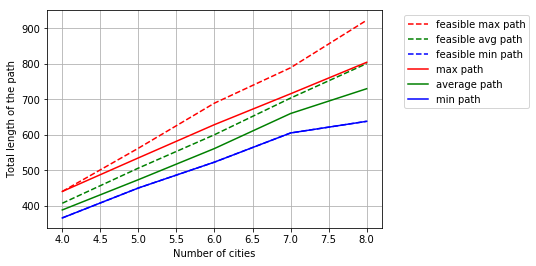

In [7]:
#data_to_set = [final_length, step, step-step_light, t_finished-t_start, t_finished-t_light]
list_avrPath = []
list_totalS_1 = []
list_totalSS = []
list_totalTfi = []
list_totalTfl = []
for data in list_op: # for each map of cities
    totalPath = 0
    totalS_1 = 0
    totalSS = 0
    totalTfi = 0
    totalTfl = 0
    for each in data:
        totalPath += each[0]
        totalS_1 += each[1]
        totalSS += each[2]
        totalTfi += each[3]
        totalTfl += each[4]
    list_avrPath.append(totalPath / len(data) )
    list_totalS_1.append(totalS_1 / len(data) )
    list_totalSS.append(totalSS / len(data) )
    list_totalTfi.append(totalTfi / len(data) )
    list_totalTfl.append(totalTfl / len(data) )
print("list_avrPath:", list_avrPath)
print("list_minPath:", list_minPath)
print("list_maxPath:", list_maxPath)
print("list_avgFeasibleRoutes:", list_avgFeasibleRoutes)
print("list_minFeasibleRoutes:", list_minFeasibleRoutes)
print("list_maxFeasibleRoutes:", list_maxFeasibleRoutes)
print("num_of_cities", num_of_cities)

plt.plot(num_of_cities, list_maxFeasibleRoutes, "--", color = "r", label = "feasible max path")
plt.plot(num_of_cities, list_avgFeasibleRoutes, "--", color = "g",label = "feasible avg path")
plt.plot(num_of_cities, list_minFeasibleRoutes, "--", color = "b",label = "feasible min path")
plt.plot(num_of_cities, list_maxPath, "-", color = "r", label = "max path")
plt.plot(num_of_cities, list_avrPath, "-", color = "g", label = "average path")
plt.plot(num_of_cities, list_minPath, "-", color = "b", label = "min path")

plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Total length of the path')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

Quality   max: [1.0817564346886333, 1.1109294621093602, 1.148660081721909, 1.1215969641500527, 1.1527494281330954]
Quality found: [0.9535208752404369, 0.9354445543276945, 0.9351413717428266, 0.9380006213739335, 0.9114115077481248]
Quality   min: [0.8981736470734007, 0.88907053789064, 0.8711918189920721, 0.8599717489193034, 0.7965386527193016]


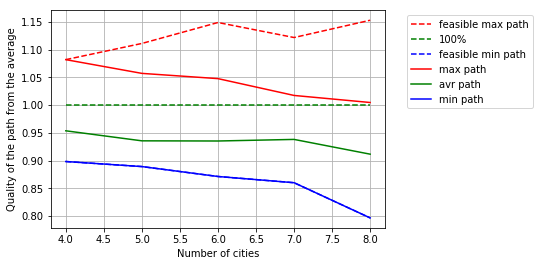

In [8]:
list_percentage = []
list_minPercentage = []
list_maxPercentage = []
list_f_minPercentage = []
list_f_maxPercentage = []
for idx, data in enumerate(list_avrPath):
    list_percentage.append(data / list_avgFeasibleRoutes[idx]) # calculate avrPath/avgFeasibleRoutes
for idx, data in enumerate(list_minPath):
    list_minPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate minPath/avgFeasibleRoutes
for idx, data in enumerate(list_maxPath):
    list_maxPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate maxPath/avgFeasibleRoutes
for idx, data in enumerate(list_minFeasibleRoutes):
    list_f_minPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate feasible minPath/avgFeasibleRoutes
for idx, data in enumerate(list_maxFeasibleRoutes):
    list_f_maxPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate feasible maxPath/avgFeasibleRoutes

print("Quality   max:", list_f_maxPercentage)
print("Quality found:", list_percentage)
print("Quality   min:", list_f_minPercentage)

plt.plot(num_of_cities, list_f_maxPercentage, "--", color = "r", label = "feasible max path")
plt.plot(num_of_cities, np.ones(len(num_of_cities)), "--", color = "g", label = "100%")
plt.plot(num_of_cities, list_f_minPercentage, "--", color = "b", label = "feasible min path")
plt.plot(num_of_cities, list_maxPercentage, "-", color = "r", label = "max path")
plt.plot(num_of_cities, list_percentage, "-", color = "g", label = "avr path")
plt.plot(num_of_cities, list_minPercentage, "-", color = "b", label = "min path")

plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Quality of the path from the average')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

list_totalS_1: [828.0813953488372, 1171.98, 1637.0824742268042, 2341.6344086021504, 2795.87]
list_totalSS: [615.1860465116279, 702.48, 805.7835051546392, 1035.021505376344, 826.13]
list_minStep: [624, 908, 1323, 1921, 2590]
list_maxStep: [1109, 1763, 2397, 3454, 3411]


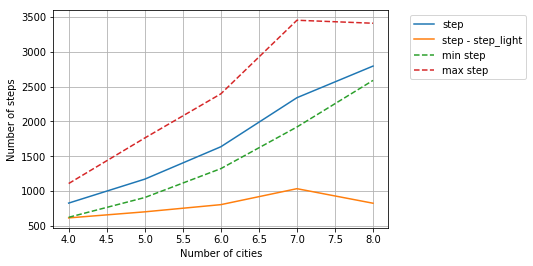

In [9]:
print("list_totalS_1:", list_totalS_1)
print("list_totalSS:", list_totalSS)
print("list_minStep:", list_minStep)
print("list_maxStep:", list_maxStep)

plt.plot(num_of_cities, list_totalS_1, "-", label = "step")
plt.plot(num_of_cities, list_totalSS, "-", label = "step - step_light")
plt.plot(num_of_cities, list_minStep, "--", label = "min step")
plt.plot(num_of_cities, list_maxStep, "--", label = "max step")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Number of steps')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

list_totalTfi: [0.44214951795313323, 1.261783166678797, 3.279365308279143, 8.436223229635894, 16.723450393120874]
list_totalTfl: [0.3251417448715751, 0.7381097653161851, 1.5709823711235773, 3.570795876990443, 4.704833193319501]
list_minTime: [0.26098602000274695, 0.9495285309967585, 2.524660910014063, 6.648449777014321, 14.995273395994445]
list_maxTime: [0.9167783969896846, 1.9855637989821844, 4.997096355014946, 12.946595010987949, 19.37624981297995]
num_of_cities [4, 5, 6, 7, 8]


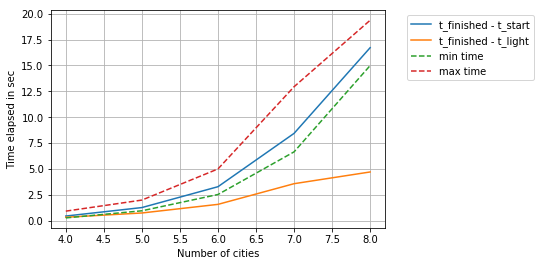

In [10]:
print("list_totalTfi:", list_totalTfi)
print("list_totalTfl:", list_totalTfl)
print("list_minTime:", list_minTime)
print("list_maxTime:", list_maxTime)
print("num_of_cities", num_of_cities)

plt.plot(num_of_cities, list_totalTfi, "-", label = "t_finished - t_start")
plt.plot(num_of_cities, list_totalTfl, "-", label = "t_finished - t_light")
plt.plot(num_of_cities, list_minTime, "--", label = "min time")
plt.plot(num_of_cities, list_maxTime, "--", label = "max time")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Time elapsed in sec')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

3 0.7007753543707013
1 1.4678083184093527
0 0.736348875846819
2 1.4730735012142373


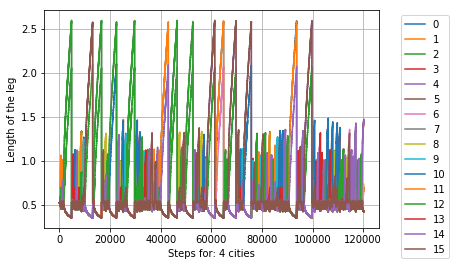

4 0.824817582788716
3 1.1371491878683326
1 1.0158990793969636
0 0.7025612859167566
2 1.1341013958178319


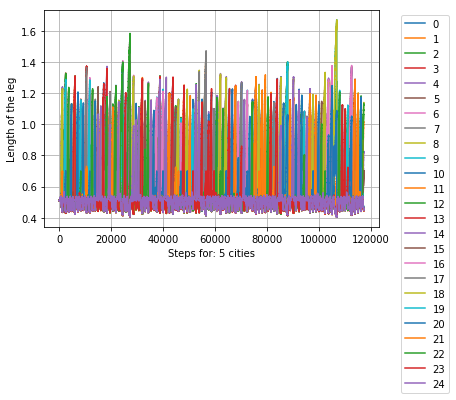

5 1.14480854621258
1 1.5618800633578171
2 0.7000110758207613
0 1.5734878883677987
4 1.1035749573684912
3 1.5646205931110218


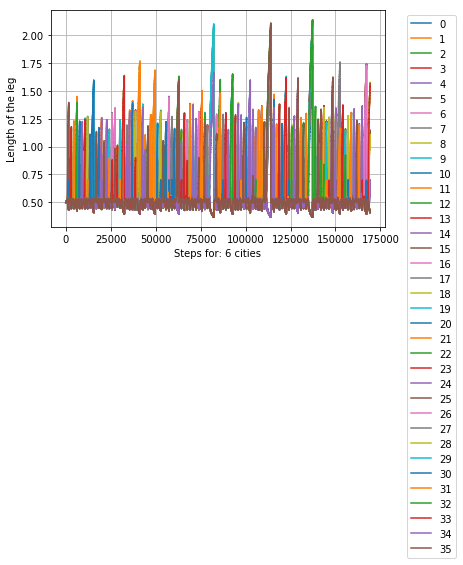

2 0.7015557484794254
6 1.4899548400852802
4 0.923360915465331
1 1.4889819137784814
5 1.3148449688049537
0 0.7198753913526617
3 1.4723881017371971


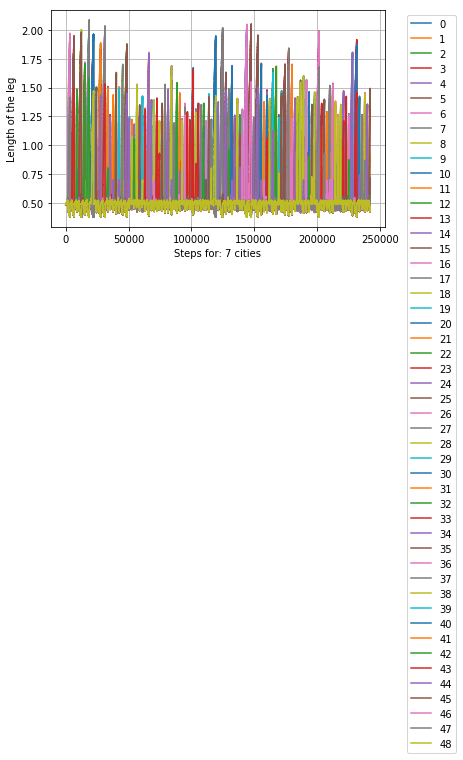

4 0.772420307229023
7 1.4067712262564465
6 0.7789513564540659
0 1.542206857741675
5 0.7027898252738775
2 1.5443287467625975
3 0.8464716327217097
1 1.5425570673388007


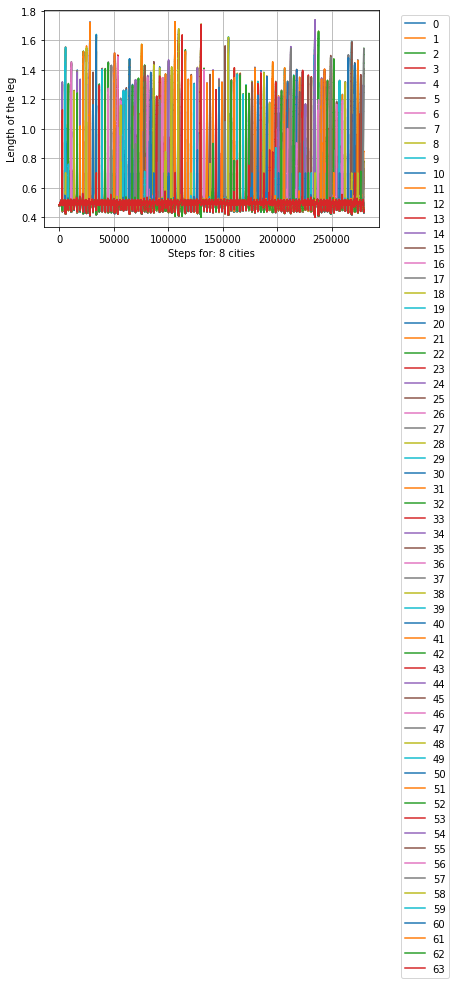

In [11]:
for idx, legdata in enumerate(list_legs):
    for i, leg in enumerate(legdata):
        if leg[-1] >= decided-0.01:
            print(i%(num_of_cities[idx]), leg[-1])
        x_values = np.arange(0, len(leg), 1)
        plt.plot(x_values, leg, "-", label = i)
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Length of the leg')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

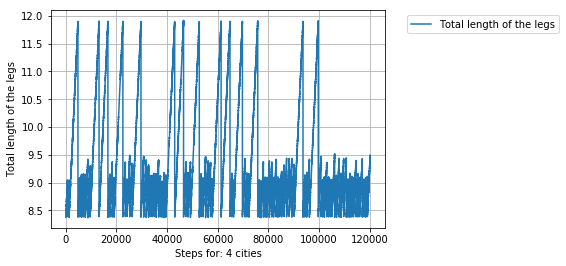

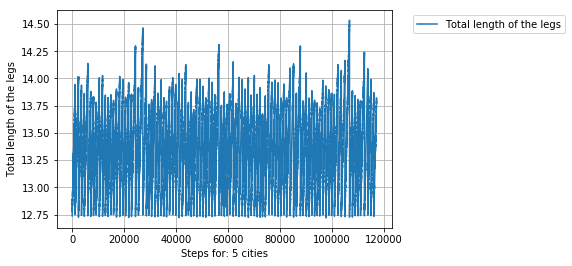

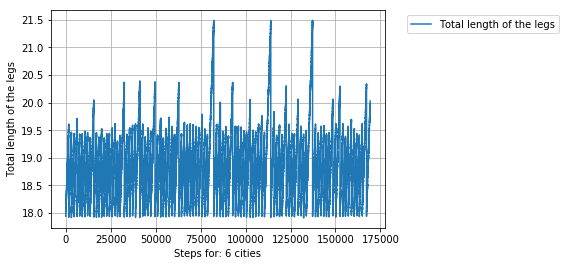

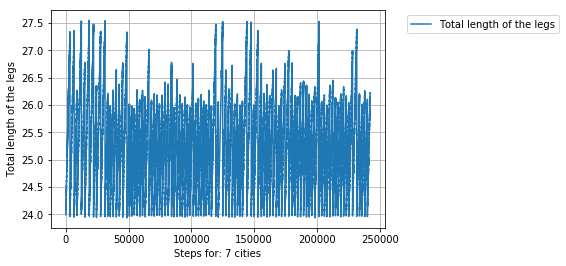

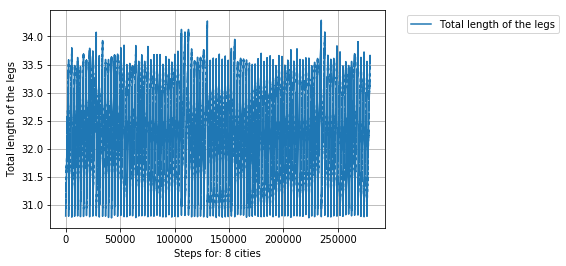

In [12]:
# statistics for  total length of legs
for idx, legdata in enumerate(list_legs):
    total_length_of_legs = np.zeros(len(legdata[0]))
    for i, leg in enumerate(legdata):
        total_length_of_legs += np.array(leg)
    x_values = np.arange(0, len(legdata[0]), 1)
    plt.plot(x_values, total_length_of_legs, "-", label = "Total length of the legs")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Total length of the legs')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

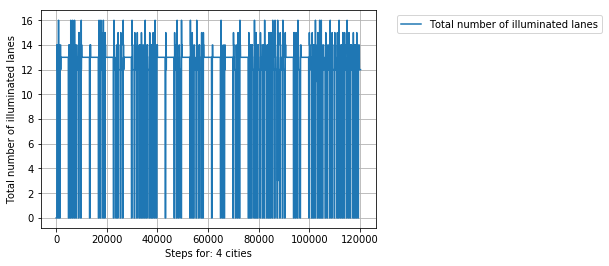

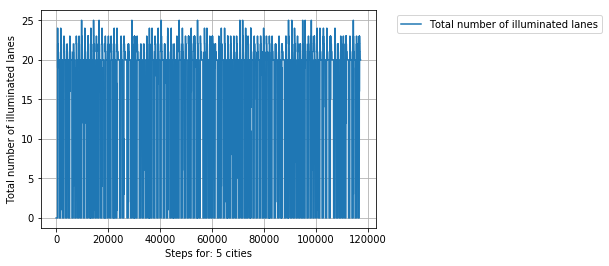

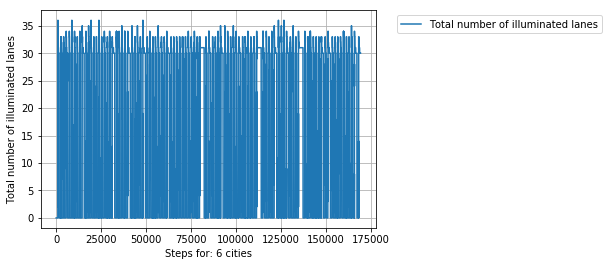

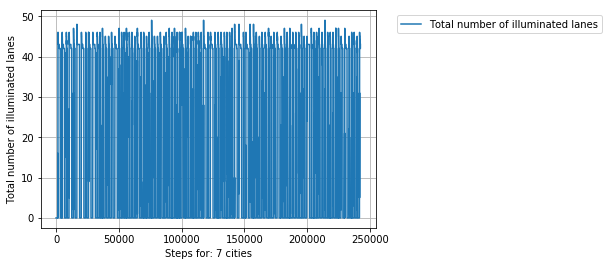

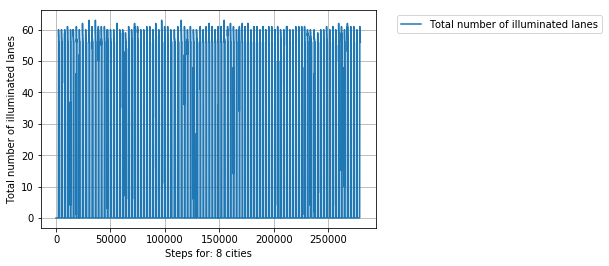

In [13]:
# statistics for  the total number of illu. lanes
for idx, illudata in enumerate(list_illu_lanes):
    x_values = np.arange(0, len(illudata), 1)
    plt.plot(x_values, illudata, "-", label = "Total number of illuminated lanes")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Total number of illuminated lanes')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

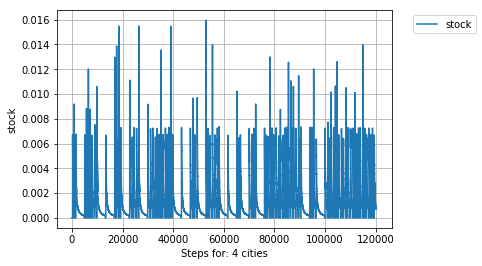

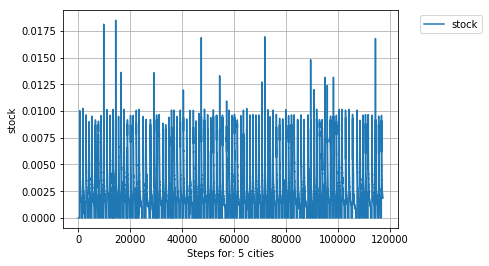

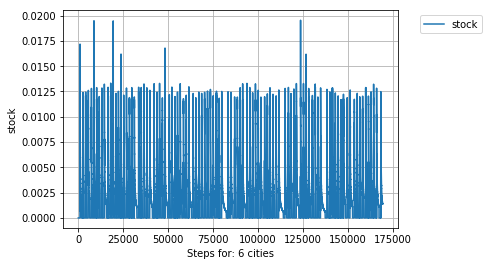

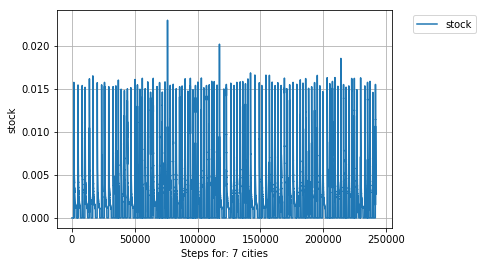

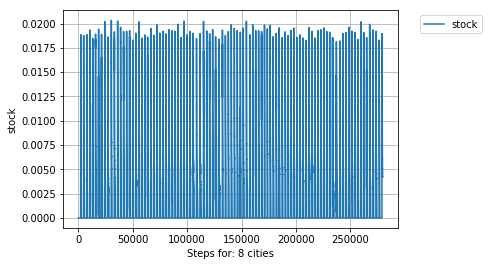

In [14]:
# statistics for  stock
for idx, stkdata in enumerate(list_stock):
    x_values = np.arange(0, len(stkdata), 1)
    plt.plot(x_values, stkdata, "-", label = "stock")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('stock')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

list_totalTfi: [0.44214951795313323, 1.261783166678797, 3.279365308279143, 8.436223229635894, 16.723450393120874]
list_time: [0.00014079100219532847, 9.023002348840237e-05, 0.00041260701254941523, 0.0022019300085958093, 0.019339555001351982]


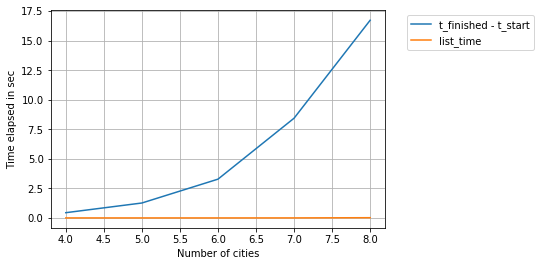

In [15]:
# statistics for time elapsed for TSP vs brute force
print("list_totalTfi:", list_totalTfi)
print("list_time:", list_time)

plt.plot(num_of_cities, list_totalTfi, "-", label = "t_finished - t_start")
plt.plot(num_of_cities, list_time, "-", label = "list_time")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Time elapsed in sec')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

## Noise!

In [16]:
## Read only global variables
TSPmode = 1 # 0 for Logistic, 1 for Noise, 2 for Sin

In [17]:
# calculate the sigmoid function
def sgm(h_0, gamma_0, theta_0):
    return 1 / ( 1 + math.exp( -gamma_0 * ( h_0 - theta_0) ) )

# update lists of illu. and ni. lanes and it's number 
def checkIlluOnLanes():
    global X_illuminated
    global X_nonilluminated    
    X_illuminated = [] # 0 <= list.len() <= NLanes
    X_nonilluminated = []
    
    illu_lanes_counter = 0
    for iLane in range(NLanes): # iLane stands for "ID for a lane"
        if(Light[iLane] <= withdraw): # if lighted less than or equal withdraw = 0.5, it's nonilluminated
            X_nonilluminated.append(iLane)
        else:
            X_illuminated.append(iLane) # else (light greater than 0.5), it's illuminated
            illu_lanes_counter += 1
    list_illu_lanes[cityId_now].append(illu_lanes_counter)

# deal with X_a, leg obtained from deltaXd, stock, total_deltaXd
def updateX(num_step):
    global X
    global X_a
    global X_b
    global stock
    global sigmoid_deltaXd
    global phases # initiated in the initiation
    
    # update X_a (distribution and gain on branches)
    ## distribution from illu.branches
    for illu_branch in X_illuminated:
        sigmoid_deltaXd[illu_branch] = 2 * deltaXd * sgm(X[illu_branch], gamma_3, theta_3) # update distribution from each lanes
        X_a[illu_branch] -= sigmoid_deltaXd[illu_branch] # remove distributed resource from legs
        
    ## gain on nonillu.branches
    for nonillu_branch in X_nonilluminated:
        X_a[nonillu_branch] += (deltaXg + stock) / len(X_nonilluminated)
    if len(X_nonilluminated) > 0: stock = 0 # remove stock if used
    
    # update stock
    stock += sigmoid_deltaXd.sum()
    sigmoid_deltaXd = np.zeros(NLanes) # remove distributions
    if len(X_nonilluminated) == 0: stock += deltaXg # if all the lanes were illu., gain extra resource to the stock
    list_stock[cityId_now].append(stock)
                            
    # update X_b (noise 0 to 1)
    if TSPmode == 0: X_b = 4 * X_b * (1 - X_b)
    elif TSPmode == 1: X_b = np.random.rand(NLanes)
    elif TSPmode == 2: 
        for iLane in range(NLanes):
            X_b[iLane] = (math.sin( num_step * freq + phases[iLane] ) + 1) / 2
    
    # update X with X_0 + X_a + fixedX_b (-amp <= fixedX_b < amp)
    X = np.array( [X_0]*NLanes ) + X_a + amplitude * 2*(0.5 - X_b)
    
    # record the legs
    for iLane in range(NLanes):
        list_legs[cityId_now][iLane].append(X[iLane])
            
# initialize X and X_0
def initialize_X():
    global X
    global X_0  
    xx, jval = .0, .0
    setval = 1 / ( NLanes - 1 ) ### !--No big meaning... Let's test!

    while jval < setval: 
        jval = sgm(xx, gamma_2, theta_2)
        xx += deltaXg / NLanes # deltaXg is the gain rate of a branch
        
    X = np.array( [xx]*NLanes )
    X_0 = xx

# judge if TSP should stop calculation or not
def judgement_TSP():
    global judgement
    judge = False # decision inside judgement_TSP()
    temp_route = np.zeros(NCity) # list of decided cities in order
    
    # check if all cities have it's one unique lane = order to visit
    for iOrder in range(NCity):
        counter = 0 # counter for decided cities in the order
        for iCity in range(NCity):
            if X[iOrder*NCity + iCity] >= decided:
                counter += 1
                temp_route[iOrder] = iCity
            if counter == 2:
                break
        if counter == 0: # city in the order is still unknown
            judge = False
            break
        elif counter == 2: # visited the same city twice
            judge = False
            break
        elif counter == 1: # decided! go on to the next city
            judge = True
    
    if judge: # check if all the city for the order is decided
        for iCity in range(NCity):
            for iOrder in range(NCity):
                if iCity == temp_route[iOrder]: # if the city is inside at the order of temp_route, go check the next city
                    break
                # if you have seen all the items in the order and couldn't find the city, that's error
                if (iOrder == NCity-1) and (iCity != temp_route[iOrder]):
                    judge = False

        judgement = judge # if judge didn't turn False here, then judgement is True
        
    
# taking total distance from Y[](=list of cities in calculated order) 
def total_path_length():
    global list_op
    global list_minPath
    global list_maxPath
    global list_minStep
    global list_maxStep
    global list_minTime
    global list_maxTime
    idc, idn = int(Y[0]), int(Y[0]) # stands for id of the current city and id of the next city
    final_length = .0
    
    for iCity in Y: # for each cities in Y, set it to id next, add distance, set it to id current
        idn = int(iCity)
        final_length += _map[idc][idn]
        idc = idn       
    final_length += _map[idn][int(Y[0])] # add distance of last visited city and first visited city
    
    data_to_go = [final_length, step, step-step_light, t_finished-t_start, t_finished-t_light]
    list_op[cityId_now].append(data_to_go) # record the result to the outside list
    if final_length < list_minPath[cityId_now]: list_minPath[cityId_now] = final_length # record max and min path
    if final_length > list_maxPath[cityId_now]: list_maxPath[cityId_now] = final_length
    if step < list_minStep[cityId_now]: list_minStep[cityId_now] = step # record max and min step
    if step > list_maxStep[cityId_now]: list_maxStep[cityId_now] = step
    if t_finished-t_start < list_minTime[cityId_now]: list_minTime[cityId_now] = t_finished-t_start # record max and min time
    if t_finished-t_start > list_maxTime[cityId_now]: list_maxTime[cityId_now] = t_finished-t_start

# calculation of nu
def calculation_nu():
    global nu
    trio = []
    
    for ci in range(NCity-2): # calculating the trio of the cities with longest path
        for cj in range(1, NCity-1):
            if ci >= cj:
                continue
            for ck in range(2, NCity):
                if cj >= ck:
                    continue
                trio.append(_map[ci][cj] + _map[cj][ck])
                trio.append(_map[ck][ci] + _map[ci][cj])
                trio.append(_map[cj][ck] + _map[ck][ci])

    longest_path = max(trio)    
    nu =  theta / longest_path - 0.00000005

## for making things shorter. If floor(lane / NCity), it is showing the order of the lane. lane%NCity shows the city
def floor(x): return math.floor(x)


## main routines=====================================
## for recording data outside trials
# list of p's data, output_p1[[final_length, step, step-step_light, t_finished-t_start, t_finished-t_light], ... ]
list_op = [[] for i in range(len(num_of_cities))]
# record the shortest and longest path, step and time calculated in the trials
list_minPath = [math.inf for i in range(len(num_of_cities))]
list_maxPath = [0 for i in range(len(num_of_cities))]
list_minStep = [math.inf for i in range(len(num_of_cities))]
list_maxStep = [0 for i in range(len(num_of_cities))]
list_minTime = [math.inf for i in range(len(num_of_cities))]
list_maxTime = [0 for i in range(len(num_of_cities))]
# record the length of legs: legs_p1 = [lane1[len, len, ...], lane2[]...]
list_legs = [[[] for j in range(num_of_cities[i]**2)] for i in range(len(num_of_cities))] 
# record the number of illuminated lanes
list_illu_lanes = [[] for i in range(len(num_of_cities))]
# record stock
list_stock = [[] for i in range(len(num_of_cities))]

# set seed here
np.random.seed(0)
trials = 100 # how many trials we do for a whole calculations
cityId_now = 0 # record which ID of the city we're working on now

for a_map in list_maps: # calculate each map
    fail = 0 # counter for failure calculation of a map
    NCity = a_map.shape[0] # .shape[0] for number of cities
    NLanes = NCity**2
    _map = a_map # global map for this cities
    Wvkul = np.zeros((NLanes, NLanes)) # weight between vk and ul: legs with large W is more light-avoiding
    
    # initialize Wvkul. % turns laneID into cityID, floor turns laneID into order
    calculation_nu() # set nu
    for v in range(NLanes):
        for u in range(NLanes):
            if v % NCity == u % NCity and floor(v / NCity) != floor(u / NCity): # same city & diff. order
                Wvkul[v, u] = -_lambda
            elif v % NCity != u % NCity and floor(v / NCity) == floor(u / NCity): # diff. cities & same order
                Wvkul[v, u] = -mu
            elif v % NCity != u % NCity and math.fabs(floor(v / NCity) - floor(u / NCity)) == 1: # diff. cities and next order
                Wvkul[v, u] = -nu * _map[v % NCity, u % NCity]
            elif v % NCity != u % NCity and math.fabs(floor(v / NCity) - floor(u / NCity)) == NCity - 1: # diff. cities and next order
                Wvkul[v, u] = -nu * _map[v % NCity, u % NCity]
            else:
                Wvkul[v, u] = 0
    
    # trials
    for trial in range(trials): # calculate for number of trials
        if trial%10 == 0: print('trial:', trial)
        t_start, t_light, t_finished = .0, .0, .0 # keep track of time for start, light being on for a step, end of step
        light_on = False # the power of light. Become False when step is over.
        step, step_light = 0, 0 # what step we're on in a step.
        X_0 = .0 # initial leg length. initialized at initialize_X()
        X, X_a, X_b, sigmoid_deltaXd = np.zeros(NLanes), np.zeros(NLanes), np.zeros(NLanes), np.zeros(NLanes)
        # length of leg, resource to be gained to legs, noise, sigmoided distribution from each illu. lanes
        Light = np.zeros(NLanes) # list of the brightness of light spotting a lane
        judgement = False # to continue the step or not
        Y = np.zeros(NCity) # list of cities in calculated order
        X_illuminated, X_nonilluminated = [], [] # record the illu. or nonillu. lanes
        stock = .0
        phases = np.zeros(NLanes) # initial angle of noise for sinTSP

        ## initializations
        t_start = time.perf_counter()
        initialize_X() # set X and X_0
        X_b = np.random.rand(NLanes) #set X_b in random
        if TSPmode == 2: phases = 2 * pi * X_b # 0 to 2pi

        ## main loop
        for s in range(MaxCyc):
            step = s
            judgement_TSP() # judge if TSP should stop calculation of this step or not
            if judgement:
                break
                
            # update Light[], list of the brightness of light spotting a lane
            for i in range(NLanes): # check Light on i
                h = .0
                for j in range(NLanes): # for each lane i, sum up relationship with other lanes
                    h += Wvkul[i, j] * sgm(X[j], gamma_2, theta_2)
                    if h < -1.2: # when h is smaller than -1.2, we can't calculate
                        h = -1.2
                        break
                Light[i] = 1 - sgm(h, gamma_1, theta_1)

            checkIlluOnLanes() # update lists of illu. and ni. lanes and it's number 
#             if (NCity == 4 and trial == 2) or (NCity == 6 and trial == 49): 
#                 print('X:', X)
#                 print('Xi:', X_illuminated)
            
            # if lights are on for the first time in a trial, update statistics for lights on
            if Light.sum() > .0 and light_on == False:
                t_light = time.perf_counter()
                step_light = step
                light_on = True

            updateX(step) # deal with X_a, leg obtained from deltaXd, stock, total_deltaXd 
            # end of a step

        if judgement == False:
            print(NCity, 'City Not found at trial:', trial)
            print(X)
            fail += 1
        else:
            for i in range(NLanes):
                if (X[i] >= decided):
                    Y[floor(i / NCity)] = int(i % NCity)
            t_finished = time.perf_counter()
            total_path_length()
        # end of a trial
        
    print("For", NCity, "fails:", fail)
    cityId_now += 1
print("finished calculation!")

trial: 0
trial: 10
4 City Not found at trial: 14
[0.35574679 0.3599294  0.35930149 2.59030921 0.36035288 0.35498648
 2.08972731 0.3558422  2.57503146 0.35637087 0.35700612 0.35699133
 0.35841811 0.3598796  0.35461433 0.35659911]
trial: 20
4 City Not found at trial: 26
[2.59801134 0.35798169 0.35493317 0.35731401 0.35906206 0.35872296
 0.35743652 0.35553994 0.35983192 0.35774921 0.35734867 2.5922932
 0.35576887 0.35619411 2.05746832 0.35534571]
trial: 30
4 City Not found at trial: 37
[0.35461937 0.35664524 2.07077658 0.35678368 0.35508788 0.35984909
 0.36030987 2.59150722 0.35877735 0.35553811 0.35687341 0.35555546
 2.58447208 0.35871417 0.35585447 0.35532283]
trial: 40
4 City Not found at trial: 41
[0.3543134  0.35848939 0.35497696 2.58725028 0.35678479 0.35832061
 2.08271643 0.35520993 2.57980507 0.35455695 0.35766456 0.35507449
 0.3573134  0.35706943 0.3547697  0.35753506]
trial: 50
4 City Not found at trial: 51
[0.35570759 0.35604841 2.06867322 0.35650451 0.35825928 0.35731772
 0.35

list_avrPath: [394.0615621924275, 477.0562305129237, 558.3745918256594, 657.3384045938578, 722.4747193794184]
list_minPath: [365.2956814808241, 449.7730203962253, 522.7758777306008, 605.0305193334461, 637.9276009558941]
list_maxPath: [439.9605302309182, 534.7277855212595, 641.7711350804062, 719.7551777491005, 797.378079367925]
list_avgFeasibleRoutes: [406.70941824122724, 505.89126647176073, 600.0697737674212, 703.5469712740761, 800.8746327351154]
list_minFeasibleRoutes: [365.29568148082416, 449.7730203962254, 522.7758777306009, 605.0305193334461, 637.9276009558943]
list_maxFeasibleRoutes: [439.96053023091815, 562.0095125472961, 689.2761953745335, 789.096147117968, 923.207774891707]
num_of_cities [4, 5, 6, 7, 8]


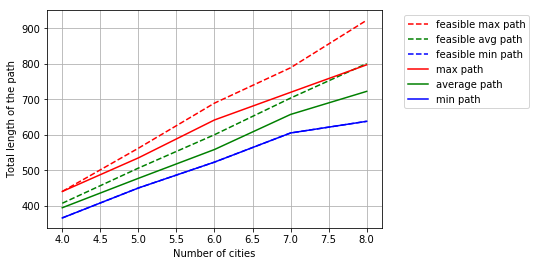

In [18]:
#data_to_set = [final_length, step, step-step_light, t_finished-t_start, t_finished-t_light]
list_avrPath = []
list_totalS_1 = []
list_totalSS = []
list_totalTfi = []
list_totalTfl = []
for data in list_op: # for each map of cities
    totalPath = 0
    totalS_1 = 0
    totalSS = 0
    totalTfi = 0
    totalTfl = 0
    for each in data:
        totalPath += each[0]
        totalS_1 += each[1]
        totalSS += each[2]
        totalTfi += each[3]
        totalTfl += each[4]
    list_avrPath.append(totalPath / len(data) )
    list_totalS_1.append(totalS_1 / len(data) )
    list_totalSS.append(totalSS / len(data) )
    list_totalTfi.append(totalTfi / len(data) )
    list_totalTfl.append(totalTfl / len(data) )
print("list_avrPath:", list_avrPath)
print("list_minPath:", list_minPath)
print("list_maxPath:", list_maxPath)
print("list_avgFeasibleRoutes:", list_avgFeasibleRoutes)
print("list_minFeasibleRoutes:", list_minFeasibleRoutes)
print("list_maxFeasibleRoutes:", list_maxFeasibleRoutes)
print("num_of_cities", num_of_cities)

plt.plot(num_of_cities, list_maxFeasibleRoutes, "--", color = "r", label = "feasible max path")
plt.plot(num_of_cities, list_avgFeasibleRoutes, "--", color = "g",label = "feasible avg path")
plt.plot(num_of_cities, list_minFeasibleRoutes, "--", color = "b",label = "feasible min path")
plt.plot(num_of_cities, list_maxPath, "-", color = "r", label = "max path")
plt.plot(num_of_cities, list_avrPath, "-", color = "g", label = "average path")
plt.plot(num_of_cities, list_minPath, "-", color = "b", label = "min path")

plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Total length of the path')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

Quality   max: [1.0817564346886333, 1.1109294621093602, 1.148660081721909, 1.1215969641500527, 1.1527494281330954]
Quality found: [0.9689019838697268, 0.943001514614116, 0.9305161103516567, 0.9343205662636317, 0.9021071336871431]
Quality   min: [0.8981736470734007, 0.88907053789064, 0.8711918189920721, 0.8599717489193034, 0.7965386527193016]


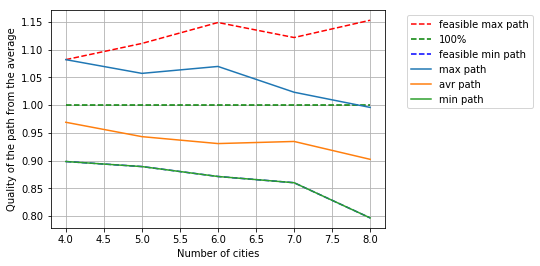

In [19]:
list_percentage = []
list_minPercentage = []
list_maxPercentage = []
list_f_minPercentage = []
list_f_maxPercentage = []
for idx, data in enumerate(list_avrPath):
    list_percentage.append(data / list_avgFeasibleRoutes[idx]) # calculate avrPath/avgFeasibleRoutes
for idx, data in enumerate(list_minPath):
    list_minPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate minPath/avgFeasibleRoutes
for idx, data in enumerate(list_maxPath):
    list_maxPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate maxPath/avgFeasibleRoutes
for idx, data in enumerate(list_minFeasibleRoutes):
    list_f_minPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate feasible minPath/avgFeasibleRoutes
for idx, data in enumerate(list_maxFeasibleRoutes):
    list_f_maxPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate feasible maxPath/avgFeasibleRoutes

print("Quality   max:", list_f_maxPercentage)
print("Quality found:", list_percentage)
print("Quality   min:", list_f_minPercentage)

plt.plot(num_of_cities, list_f_maxPercentage, "--", color = "r", label = "feasible max path")
plt.plot(num_of_cities, np.ones(len(num_of_cities)), "--", color = "g", label = "100%")
plt.plot(num_of_cities, list_f_minPercentage, "--", color = "b", label = "feasible min path")
plt.plot(num_of_cities, list_maxPercentage, "-", label = "max path")
plt.plot(num_of_cities, list_percentage, "-", label = "avr path")
plt.plot(num_of_cities, list_minPercentage, "-", label = "min path")

plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Quality of the path from the average')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

list_totalS_1: [857.0909090909091, 1206.24, 1615.73, 2310.2934782608695, 2759.98]
list_totalSS: [640.6931818181819, 731.33, 775.03, 993.5217391304348, 775.03]
list_minStep: [615, 949, 1327, 1882, 2531]
list_maxStep: [1148, 1707, 2385, 3334, 3401]


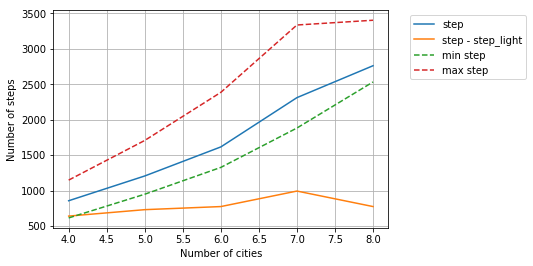

In [20]:
print("list_totalS_1:", list_totalS_1)
print("list_totalSS:", list_totalSS)
print("list_minStep:", list_minStep)
print("list_maxStep:", list_maxStep)

plt.plot(num_of_cities, list_totalS_1, "-", label = "step")
plt.plot(num_of_cities, list_totalSS, "-", label = "step - step_light")
plt.plot(num_of_cities, list_minStep, "--", label = "min step")
plt.plot(num_of_cities, list_maxStep, "--", label = "max step")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Number of steps')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

list_totalTfi: [0.38825378575116204, 1.1906836630502948, 3.2406967263715343, 7.984188634716544, 15.902880301629484]
list_totalTfl: [0.28617370126151154, 0.7061831377804628, 1.5061319832806475, 3.274125559194426, 4.266777240829542]
list_minTime: [0.2649416009953711, 0.8951471820182633, 2.5175626059935894, 6.524690680002095, 14.208976831985638]
list_maxTime: [0.5174141290190164, 1.8505229669972323, 4.688404795975657, 11.846786615991732, 20.101751348003745]
num_of_cities [4, 5, 6, 7, 8]


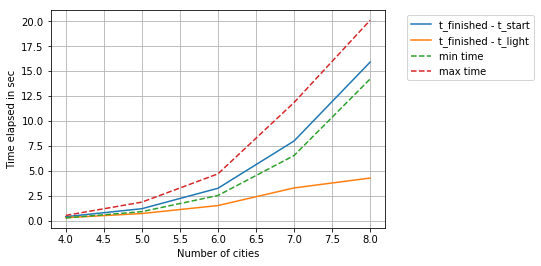

In [21]:
print("list_totalTfi:", list_totalTfi)
print("list_totalTfl:", list_totalTfl)
print("list_minTime:", list_minTime)
print("list_maxTime:", list_maxTime)
print("num_of_cities", num_of_cities)

plt.plot(num_of_cities, list_totalTfi, "-", label = "t_finished - t_start")
plt.plot(num_of_cities, list_totalTfl, "-", label = "t_finished - t_light")
plt.plot(num_of_cities, list_minTime, "--", label = "min time")
plt.plot(num_of_cities, list_maxTime, "--", label = "max time")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Time elapsed in sec')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

0 0.7004397983638313
3 0.9879777839153077
2 0.7669518534777876
1 0.9779206615004562


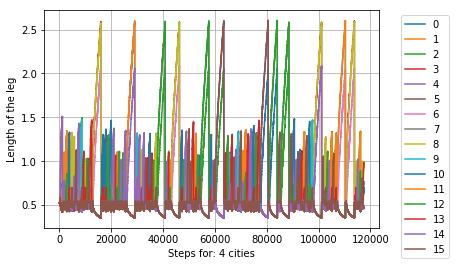

0 0.7019853492598469
4 1.3225504461707767
2 1.3181442347363244
1 0.7528987003465684
3 1.3197701183623831


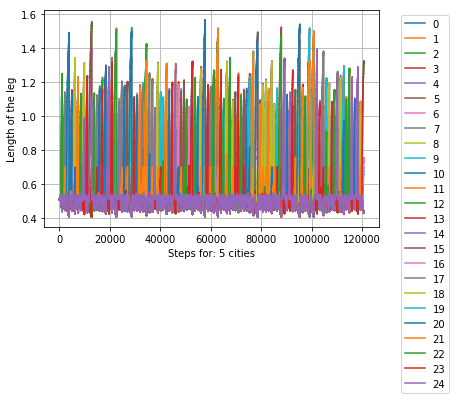

5 1.119614040795247
0 0.7183063169365126
4 1.0574015800359498
2 1.1159480545686649
3 0.7026000802535864
1 1.121925221641243


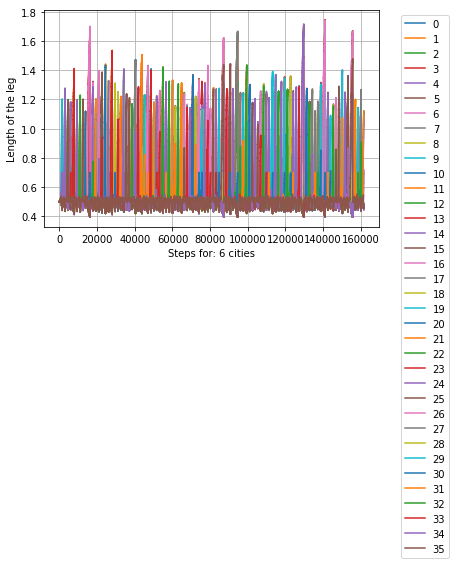

3 1.716637174982423
1 1.3127162987776841
4 1.7239447737985865
6 1.551965334029244
0 1.0791307362413785
5 1.7155643084626342
2 0.7012077950597538


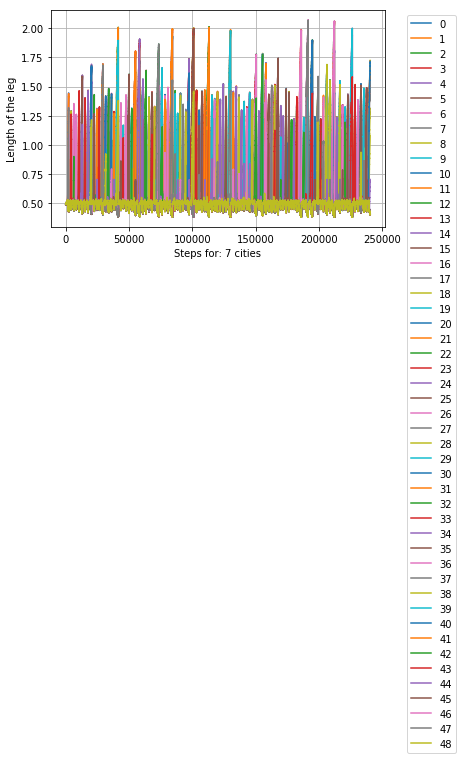

6 1.485246366805002
0 0.7969313800148953
5 1.4767106267375176
2 0.8469640130390419
3 1.4831833224653928
7 0.7000220906468076
4 1.47938163042171
1 0.8290034577848949


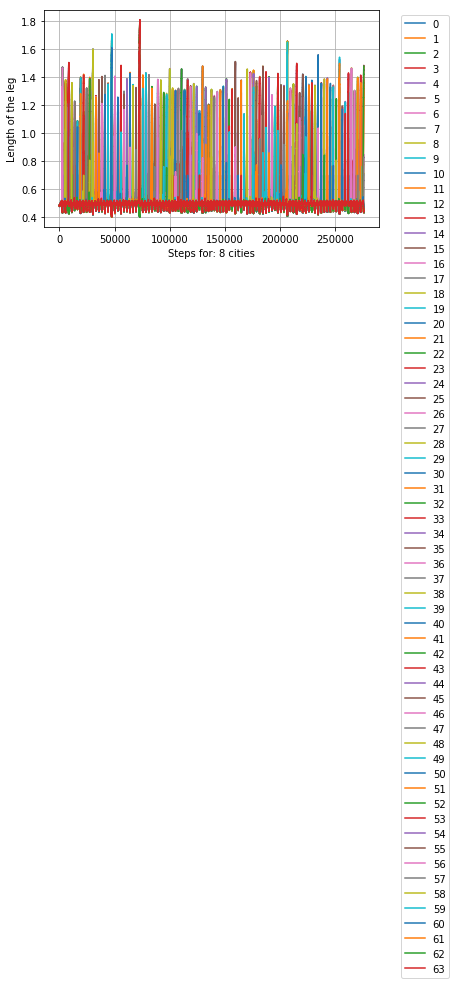

In [22]:
for idx, legdata in enumerate(list_legs):
    for i, leg in enumerate(legdata):
        if leg[-1] >= decided-0.01:
            print(i%(num_of_cities[idx]), leg[-1])
        x_values = np.arange(0, len(leg), 1)
        plt.plot(x_values, leg, "-", label = i)
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Length of the leg')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

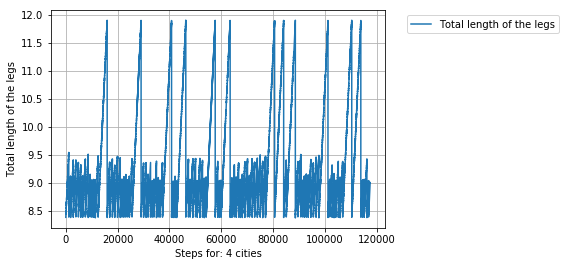

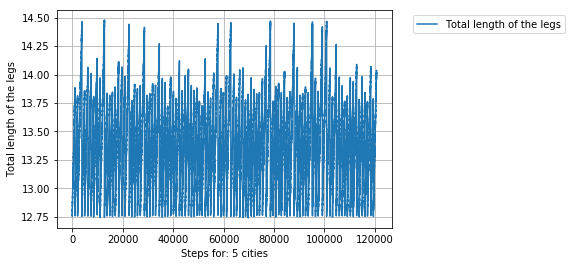

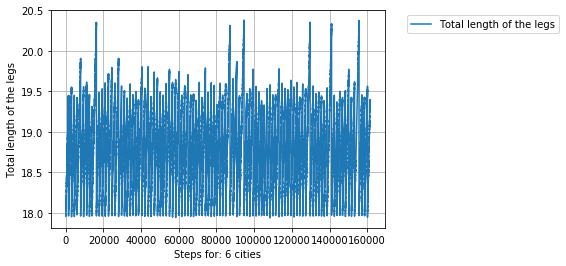

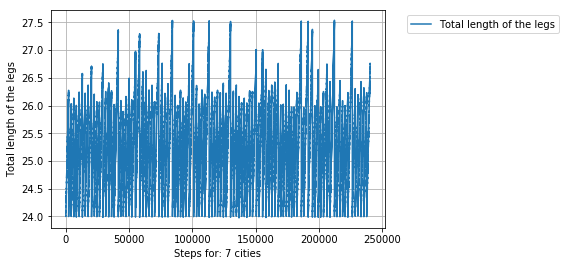

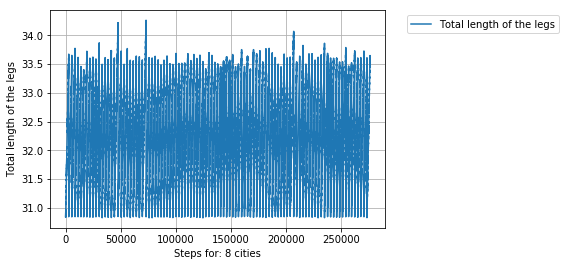

In [23]:
# statistics for  total length of legs
for idx, legdata in enumerate(list_legs):
    total_length_of_legs = np.zeros(len(legdata[0]))
    for i, leg in enumerate(legdata):
        total_length_of_legs += np.array(leg)
    x_values = np.arange(0, len(legdata[0]), 1)
    plt.plot(x_values, total_length_of_legs, "-", label = "Total length of the legs")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Total length of the legs')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

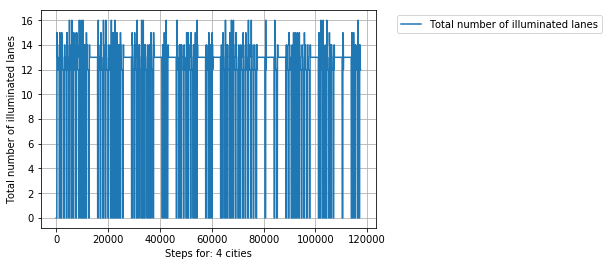

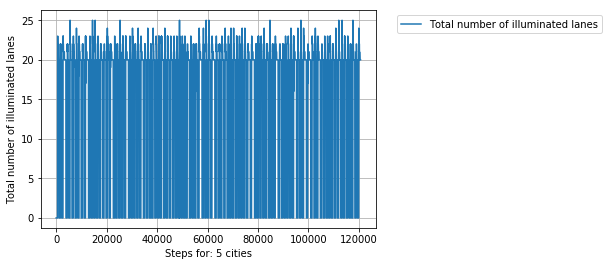

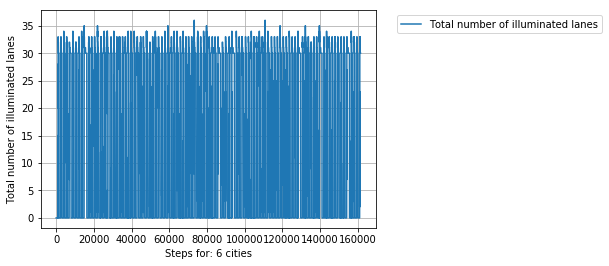

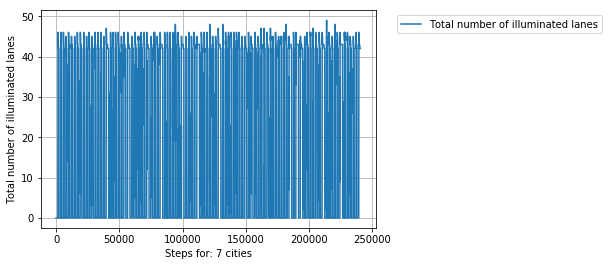

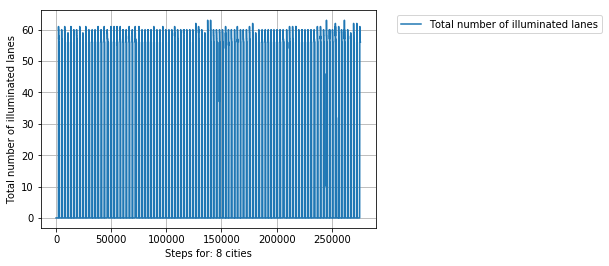

In [24]:
# statistics for  the total number of illu. lanes
for idx, illudata in enumerate(list_illu_lanes):
    x_values = np.arange(0, len(illudata), 1)
    plt.plot(x_values, illudata, "-", label = "Total number of illuminated lanes")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Total number of illuminated lanes')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

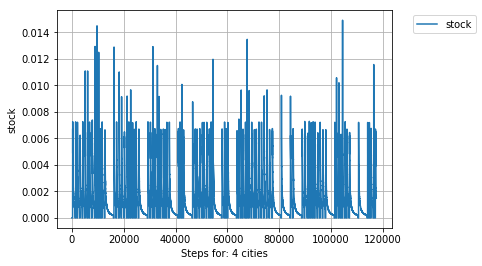

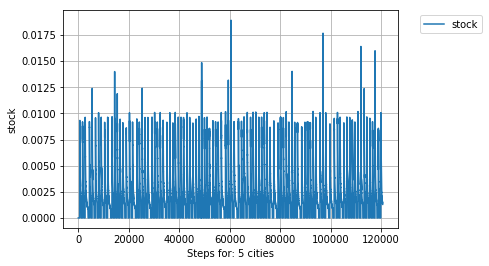

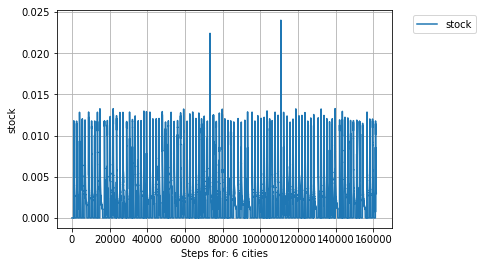

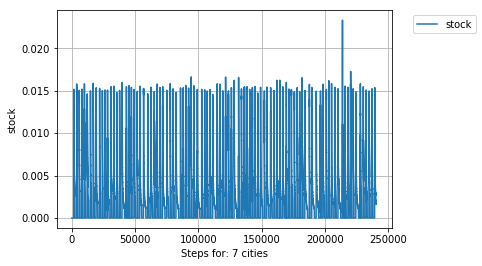

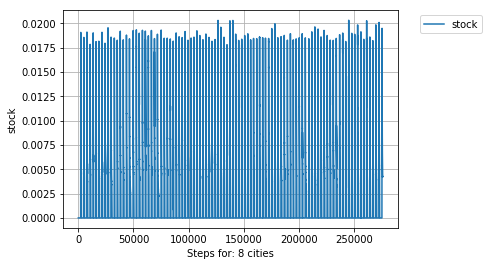

In [25]:
# statistics for  stock
for idx, stkdata in enumerate(list_stock):
    x_values = np.arange(0, len(stkdata), 1)
    plt.plot(x_values, stkdata, "-", label = "stock")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('stock')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

list_totalTfi: [0.38825378575116204, 1.1906836630502948, 3.2406967263715343, 7.984188634716544, 15.902880301629484]
list_time: [0.00014079100219532847, 9.023002348840237e-05, 0.00041260701254941523, 0.0022019300085958093, 0.019339555001351982]


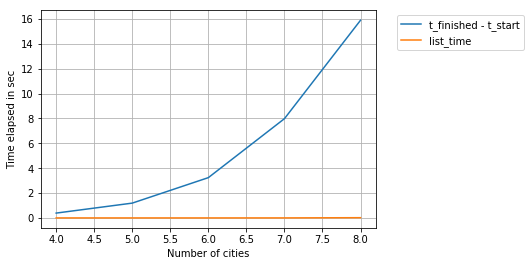

In [26]:
# statistics for time elapsed for TSP vs brute force
print("list_totalTfi:", list_totalTfi)
print("list_time:", list_time)

plt.plot(num_of_cities, list_totalTfi, "-", label = "t_finished - t_start")
plt.plot(num_of_cities, list_time, "-", label = "list_time")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Time elapsed in sec')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

## Sin!

In [27]:
TSPmode = 2 # 0 for Logistic, 1 for Noise, 2 for Sin

In [28]:
# calculate the sigmoid function
def sgm(h_0, gamma_0, theta_0):
    return 1 / ( 1 + math.exp( -gamma_0 * ( h_0 - theta_0) ) )

# update lists of illu. and ni. lanes and it's number 
def checkIlluOnLanes():
    global X_illuminated
    global X_nonilluminated    
    X_illuminated = [] # 0 <= list.len() <= NLanes
    X_nonilluminated = []
    
    illu_lanes_counter = 0
    for iLane in range(NLanes): # iLane stands for "ID for a lane"
        if(Light[iLane] <= withdraw): # if lighted less than or equal withdraw = 0.5, it's nonilluminated
            X_nonilluminated.append(iLane)
        else:
            X_illuminated.append(iLane) # else (light greater than 0.5), it's illuminated
            illu_lanes_counter += 1
    list_illu_lanes[cityId_now].append(illu_lanes_counter)

# deal with X_a, leg obtained from deltaXd, stock, total_deltaXd
def updateX(num_step):
    global X
    global X_a
    global X_b
    global stock
    global sigmoid_deltaXd
    global phases # initiated in the initiation
    
    # update X_a (distribution and gain on branches)
    ## distribution from illu.branches
    for illu_branch in X_illuminated:
        sigmoid_deltaXd[illu_branch] = 2 * deltaXd * sgm(X[illu_branch], gamma_3, theta_3) # update distribution from each lanes
        X_a[illu_branch] -= sigmoid_deltaXd[illu_branch] # remove distributed resource from legs
        
    ## gain on nonillu.branches
    for nonillu_branch in X_nonilluminated:
        X_a[nonillu_branch] += (deltaXg + stock) / len(X_nonilluminated)
    if len(X_nonilluminated) > 0: stock = 0 # remove stock if used
    
    # update stock
    stock += sigmoid_deltaXd.sum()
    sigmoid_deltaXd = np.zeros(NLanes) # remove distributions
    if len(X_nonilluminated) == 0: stock += deltaXg # if all the lanes were illu., gain extra resource to the stock
    list_stock[cityId_now].append(stock)
                            
    # update X_b (noise 0 to 1)
    if TSPmode == 0: X_b = 4 * X_b * (1 - X_b)
    elif TSPmode == 1: X_b = np.random.rand(NLanes)
    elif TSPmode == 2: 
        for iLane in range(NLanes):
            X_b[iLane] = (math.sin( num_step * freq + phases[iLane] ) + 1) / 2
    
    # update X with X_0 + X_a + fixedX_b (-amp <= fixedX_b < amp)
    X = np.array( [X_0]*NLanes ) + X_a + amplitude * 2*(0.5 - X_b)
    
    # record the legs
    for iLane in range(NLanes):
        list_legs[cityId_now][iLane].append(X[iLane])
            
# initialize X and X_0
def initialize_X():
    global X
    global X_0  
    xx, jval = .0, .0
    setval = 1 / ( NLanes - 1 ) ### !--No big meaning... Let's test!

    while jval < setval: 
        jval = sgm(xx, gamma_2, theta_2)
        xx += deltaXg / NLanes # deltaXg is the gain rate of a branch
        
    X = np.array( [xx]*NLanes )
    X_0 = xx

# judge if TSP should stop calculation or not
def judgement_TSP():
    global judgement
    judge = False # decision inside judgement_TSP()
    temp_route = np.zeros(NCity) # list of decided cities in order
    
    # check if all cities have it's one unique lane = order to visit
    for iOrder in range(NCity):
        counter = 0 # counter for decided cities in the order
        for iCity in range(NCity):
            if X[iOrder*NCity + iCity] >= decided:
                counter += 1
                temp_route[iOrder] = iCity
            if counter == 2:
                break
        if counter == 0: # city in the order is still unknown
            judge = False
            break
        elif counter == 2: # visited the same city twice
            judge = False
            break
        elif counter == 1: # decided! go on to the next city
            judge = True
    
    if judge: # check if all the city for the order is decided
        for iCity in range(NCity):
            for iOrder in range(NCity):
                if iCity == temp_route[iOrder]: # if the city is inside at the order of temp_route, go check the next city
                    break
                # if you have seen all the items in the order and couldn't find the city, that's error
                if (iOrder == NCity-1) and (iCity != temp_route[iOrder]):
                    judge = False

        judgement = judge # if judge didn't turn False here, then judgement is True
        
    
# taking total distance from Y[](=list of cities in calculated order) 
def total_path_length():
    global list_op
    global list_minPath
    global list_maxPath
    global list_minStep
    global list_maxStep
    global list_minTime
    global list_maxTime
    idc, idn = int(Y[0]), int(Y[0]) # stands for id of the current city and id of the next city
    final_length = .0
    
    for iCity in Y: # for each cities in Y, set it to id next, add distance, set it to id current
        idn = int(iCity)
        final_length += _map[idc][idn]
        idc = idn       
    final_length += _map[idn][int(Y[0])] # add distance of last visited city and first visited city
    
    data_to_go = [final_length, step, step-step_light, t_finished-t_start, t_finished-t_light]
    list_op[cityId_now].append(data_to_go) # record the result to the outside list
    if final_length < list_minPath[cityId_now]: list_minPath[cityId_now] = final_length # record max and min path
    if final_length > list_maxPath[cityId_now]: list_maxPath[cityId_now] = final_length
    if step < list_minStep[cityId_now]: list_minStep[cityId_now] = step # record max and min step
    if step > list_maxStep[cityId_now]: list_maxStep[cityId_now] = step
    if t_finished-t_start < list_minTime[cityId_now]: list_minTime[cityId_now] = t_finished-t_start # record max and min time
    if t_finished-t_start > list_maxTime[cityId_now]: list_maxTime[cityId_now] = t_finished-t_start

# calculation of nu
def calculation_nu():
    global nu
    trio = []
    
    for ci in range(NCity-2): # calculating the trio of the cities with longest path
        for cj in range(1, NCity-1):
            if ci >= cj:
                continue
            for ck in range(2, NCity):
                if cj >= ck:
                    continue
                trio.append(_map[ci][cj] + _map[cj][ck])
                trio.append(_map[ck][ci] + _map[ci][cj])
                trio.append(_map[cj][ck] + _map[ck][ci])

    longest_path = max(trio)    
    nu =  theta / longest_path - 0.00000005

## for making things shorter. If floor(lane / NCity), it is showing the order of the lane. lane%NCity shows the city
def floor(x): return math.floor(x)


## main routines=====================================
## for recording data outside trials
# list of p's data, output_p1[[final_length, step, step-step_light, t_finished-t_start, t_finished-t_light], ... ]
list_op = [[] for i in range(len(num_of_cities))]
# record the shortest and longest path, step and time calculated in the trials
list_minPath = [math.inf for i in range(len(num_of_cities))]
list_maxPath = [0 for i in range(len(num_of_cities))]
list_minStep = [math.inf for i in range(len(num_of_cities))]
list_maxStep = [0 for i in range(len(num_of_cities))]
list_minTime = [math.inf for i in range(len(num_of_cities))]
list_maxTime = [0 for i in range(len(num_of_cities))]
# record the length of legs: legs_p1 = [lane1[len, len, ...], lane2[]...]
list_legs = [[[] for j in range(num_of_cities[i]**2)] for i in range(len(num_of_cities))] 
# record the number of illuminated lanes
list_illu_lanes = [[] for i in range(len(num_of_cities))]
# record stock
list_stock = [[] for i in range(len(num_of_cities))]

# set seed here
np.random.seed(0)
trials = 100 # how many trials we do for a whole calculations
cityId_now = 0 # record which ID of the city we're working on now

for a_map in list_maps: # calculate each map
    fail = 0 # counter for failure calculation of a map
    NCity = a_map.shape[0] # .shape[0] for number of cities
    NLanes = NCity**2
    _map = a_map # global map for this cities
    Wvkul = np.zeros((NLanes, NLanes)) # weight between vk and ul: legs with large W is more light-avoiding
    
    # initialize Wvkul. % turns laneID into cityID, floor turns laneID into order
    calculation_nu() # set nu
    for v in range(NLanes):
        for u in range(NLanes):
            if v % NCity == u % NCity and floor(v / NCity) != floor(u / NCity): # same city & diff. order
                Wvkul[v, u] = -_lambda
            elif v % NCity != u % NCity and floor(v / NCity) == floor(u / NCity): # diff. cities & same order
                Wvkul[v, u] = -mu
            elif v % NCity != u % NCity and math.fabs(floor(v / NCity) - floor(u / NCity)) == 1: # diff. cities and next order
                Wvkul[v, u] = -nu * _map[v % NCity, u % NCity]
            elif v % NCity != u % NCity and math.fabs(floor(v / NCity) - floor(u / NCity)) == NCity - 1: # diff. cities and next order
                Wvkul[v, u] = -nu * _map[v % NCity, u % NCity]
            else:
                Wvkul[v, u] = 0
    
    # trials
    for trial in range(trials): # calculate for number of trials
        if trial%10 == 0: print('trial:', trial)
        t_start, t_light, t_finished = .0, .0, .0 # keep track of time for start, light being on for a step, end of step
        light_on = False # the power of light. Become False when step is over.
        step, step_light = 0, 0 # what step we're on in a step.
        X_0 = .0 # initial leg length. initialized at initialize_X()
        X, X_a, X_b, sigmoid_deltaXd = np.zeros(NLanes), np.zeros(NLanes), np.zeros(NLanes), np.zeros(NLanes)
        # length of leg, resource to be gained to legs, noise, sigmoided distribution from each illu. lanes
        Light = np.zeros(NLanes) # list of the brightness of light spotting a lane
        judgement = False # to continue the step or not
        Y = np.zeros(NCity) # list of cities in calculated order
        X_illuminated, X_nonilluminated = [], [] # record the illu. or nonillu. lanes
        stock = .0
        phases = np.zeros(NLanes) # initial angle of noise for sinTSP

        ## initializations
        t_start = time.perf_counter()
        initialize_X() # set X and X_0
        X_b = np.random.rand(NLanes) #set X_b in random
        if TSPmode == 2: phases = 2 * pi * X_b # 0 to 2pi

        ## main loop
        for s in range(MaxCyc):
            step = s
            judgement_TSP() # judge if TSP should stop calculation of this step or not
            if judgement:
                break
                
            # update Light[], list of the brightness of light spotting a lane
            for i in range(NLanes): # check Light on i
                h = .0
                for j in range(NLanes): # for each lane i, sum up relationship with other lanes
                    h += Wvkul[i, j] * sgm(X[j], gamma_2, theta_2)
                    if h < -1.2: # when h is smaller than -1.2, we can't calculate
                        h = -1.2
                        break
                Light[i] = 1 - sgm(h, gamma_1, theta_1)

            checkIlluOnLanes() # update lists of illu. and ni. lanes and it's number 
#             if (NCity == 4 and trial == 2) or (NCity == 6 and trial == 49): 
#                 print('X:', X)
#                 print('Xi:', X_illuminated)
            
            # if lights are on for the first time in a trial, update statistics for lights on
            if Light.sum() > .0 and light_on == False:
                t_light = time.perf_counter()
                step_light = step
                light_on = True

            updateX(step) # deal with X_a, leg obtained from deltaXd, stock, total_deltaXd 
            # end of a step

        if judgement == False:
            print(NCity, 'City Not found at trial:', trial)
            print(X)
            fail += 1
        else:
            for i in range(NLanes):
                if (X[i] >= decided):
                    Y[floor(i / NCity)] = int(i % NCity)
            t_finished = time.perf_counter()
            total_path_length()
        # end of a trial
        
    print("For", NCity, "fails:", fail)
    cityId_now += 1
print("finished calculation!")

trial: 0
trial: 10
4 City Not found at trial: 13
[2.60197385 0.35500529 0.3551535  0.35594732 0.35924672 0.35675426
 2.04723413 0.35845118 0.35792098 0.35889881 0.36050014 2.59801718
 0.35960978 0.35703271 0.35703004 0.35677156]
trial: 20
4 City Not found at trial: 25
[0.35999629 0.35471218 2.05110113 0.35447918 0.35541129 0.35971043
 0.35834928 2.59613867 0.35954965 0.35424476 0.35659439 0.36026574
 2.59409119 0.35697156 0.35607896 0.35656711]
4 City Not found at trial: 26
[2.59458255 0.35418952 0.35498567 0.35952288 0.35497082 0.35401043
 2.05649338 0.35596702 0.35931919 0.35989731 0.35464794 2.59406584
 0.35697914 0.35895612 0.35705139 0.35898897]
trial: 30
4 City Not found at trial: 35
[0.35957569 0.35469024 2.06180595 0.35564113 0.36000192 0.3564876
 0.36003314 2.58375182 0.35702544 0.35421386 0.35477836 0.35406829
 2.59695913 0.35879399 0.35522512 0.3574173 ]
4 City Not found at trial: 37
[0.35891734 0.36013191 2.06579198 0.35453346 2.59396238 0.35999301
 0.35922662 0.35413742 0.

For 7 fails: 10
trial: 0
trial: 10
trial: 20
trial: 30
trial: 40
trial: 50
trial: 60
trial: 70
trial: 80
trial: 90
For 8 fails: 0
finished calculation!


list_avrPath: [390.1142303147053, 478.42232387646516, 560.8602551850098, 657.9419698447582, 725.9394077822309]
list_minPath: [365.2956814808241, 449.7730203962253, 522.7758777306008, 605.0305193334461, 637.9276009558943]
list_maxPath: [439.9605302309182, 534.7277855212595, 628.6024648149133, 720.8360581434985, 807.1930232473476]
list_avgFeasibleRoutes: [406.70941824122724, 505.89126647176073, 600.0697737674212, 703.5469712740761, 800.8746327351154]
list_minFeasibleRoutes: [365.29568148082416, 449.7730203962254, 522.7758777306009, 605.0305193334461, 637.9276009558943]
list_maxFeasibleRoutes: [439.96053023091815, 562.0095125472961, 689.2761953745335, 789.096147117968, 923.207774891707]
num_of_cities [4, 5, 6, 7, 8]


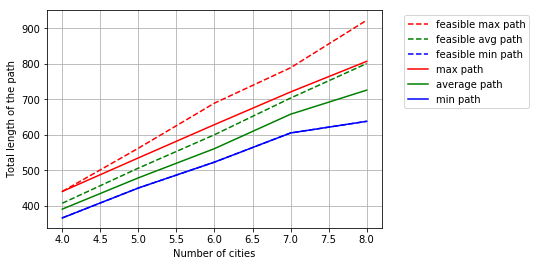

In [29]:
#data_to_set = [final_length, step, step-step_light, t_finished-t_start, t_finished-t_light]
list_avrPath = []
list_totalS_1 = []
list_totalSS = []
list_totalTfi = []
list_totalTfl = []
for data in list_op: # for each map of cities
    totalPath = 0
    totalS_1 = 0
    totalSS = 0
    totalTfi = 0
    totalTfl = 0
    for each in data:
        totalPath += each[0]
        totalS_1 += each[1]
        totalSS += each[2]
        totalTfi += each[3]
        totalTfl += each[4]
    list_avrPath.append(totalPath / len(data) )
    list_totalS_1.append(totalS_1 / len(data) )
    list_totalSS.append(totalSS / len(data) )
    list_totalTfi.append(totalTfi / len(data) )
    list_totalTfl.append(totalTfl / len(data) )
print("list_avrPath:", list_avrPath)
print("list_minPath:", list_minPath)
print("list_maxPath:", list_maxPath)
print("list_avgFeasibleRoutes:", list_avgFeasibleRoutes)
print("list_minFeasibleRoutes:", list_minFeasibleRoutes)
print("list_maxFeasibleRoutes:", list_maxFeasibleRoutes)
print("num_of_cities", num_of_cities)

plt.plot(num_of_cities, list_maxFeasibleRoutes, "--", color = "r", label = "feasible max path")
plt.plot(num_of_cities, list_avgFeasibleRoutes, "--", color = "g",label = "feasible avg path")
plt.plot(num_of_cities, list_minFeasibleRoutes, "--", color = "b",label = "feasible min path")
plt.plot(num_of_cities, list_maxPath, "-", color = "r", label = "max path")
plt.plot(num_of_cities, list_avrPath, "-", color = "g", label = "average path")
plt.plot(num_of_cities, list_minPath, "-", color = "b", label = "min path")

plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Total length of the path')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

Quality   max: [1.0817564346886333, 1.1109294621093602, 1.148660081721909, 1.1215969641500527, 1.1527494281330954]
Quality found: [0.9591964503839471, 0.9457018841482038, 0.9346584009118771, 0.9351784553251217, 0.9064332644711587]
Quality   min: [0.8981736470734007, 0.88907053789064, 0.8711918189920721, 0.8599717489193034, 0.7965386527193016]


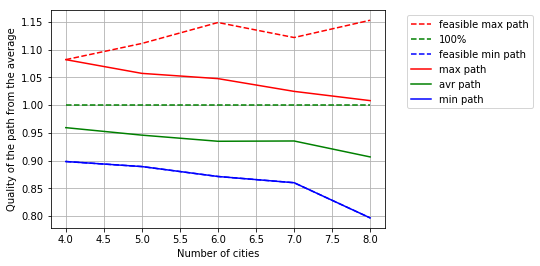

In [30]:
list_percentage = []
list_minPercentage = []
list_maxPercentage = []
list_f_minPercentage = []
list_f_maxPercentage = []
for idx, data in enumerate(list_avrPath):
    list_percentage.append(data / list_avgFeasibleRoutes[idx]) # calculate avrPath/avgFeasibleRoutes
for idx, data in enumerate(list_minPath):
    list_minPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate minPath/avgFeasibleRoutes
for idx, data in enumerate(list_maxPath):
    list_maxPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate maxPath/avgFeasibleRoutes
for idx, data in enumerate(list_minFeasibleRoutes):
    list_f_minPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate feasible minPath/avgFeasibleRoutes
for idx, data in enumerate(list_maxFeasibleRoutes):
    list_f_maxPercentage.append(data / list_avgFeasibleRoutes[idx]) # calculate feasible maxPath/avgFeasibleRoutes

print("Quality   max:", list_f_maxPercentage)
print("Quality found:", list_percentage)
print("Quality   min:", list_f_minPercentage)

plt.plot(num_of_cities, list_f_maxPercentage, "--", color = "r", label = "feasible max path")
plt.plot(num_of_cities, np.ones(len(num_of_cities)), "--", color = "g", label = "100%")
plt.plot(num_of_cities, list_f_minPercentage, "--", color = "b", label = "feasible min path")
plt.plot(num_of_cities, list_maxPercentage, "-", color = "r", label = "max path")
plt.plot(num_of_cities, list_percentage, "-", color = "g", label = "avr path")
plt.plot(num_of_cities, list_minPercentage, "-", color = "b", label = "min path")

plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Quality of the path from the average')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

list_totalS_1: [830.3483146067416, 1248.45, 1590.24, 2287.322222222222, 2757.24]
list_totalSS: [610.943820224719, 772.02, 748.64, 968.7222222222222, 771.96]
list_minStep: [608, 970, 1350, 1881, 2557]
list_maxStep: [1090, 1709, 2396, 3458, 3242]


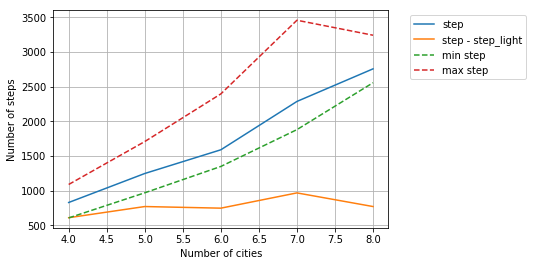

In [31]:
print("list_totalS_1:", list_totalS_1)
print("list_totalSS:", list_totalSS)
print("list_minStep:", list_minStep)
print("list_maxStep:", list_maxStep)

plt.plot(num_of_cities, list_totalS_1, "-", label = "step")
plt.plot(num_of_cities, list_totalSS, "-", label = "step - step_light")
plt.plot(num_of_cities, list_minStep, "--", label = "min step")
plt.plot(num_of_cities, list_maxStep, "--", label = "max step")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Number of steps')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

list_totalTfi: [0.3699570220654433, 1.1646832680693477, 3.0453445349712274, 7.798598754755544, 15.411100350361375]
list_totalTfl: [0.2686350648085393, 0.7032222387182991, 1.3886927830803324, 3.1503530829543402, 4.087806706149713]
list_minTime: [0.2494917630101554, 0.8741449470107909, 2.418802047992358, 6.135141583014047, 13.998667341977125]
list_maxTime: [0.724684985994827, 1.5935555910109542, 4.628315415990073, 12.210591013019439, 18.041729429998668]
num_of_cities [4, 5, 6, 7, 8]


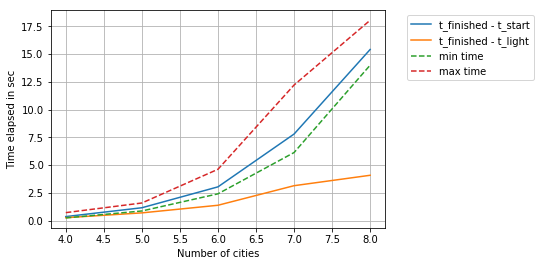

In [32]:
print("list_totalTfi:", list_totalTfi)
print("list_totalTfl:", list_totalTfl)
print("list_minTime:", list_minTime)
print("list_maxTime:", list_maxTime)
print("num_of_cities", num_of_cities)

plt.plot(num_of_cities, list_totalTfi, "-", label = "t_finished - t_start")
plt.plot(num_of_cities, list_totalTfl, "-", label = "t_finished - t_light")
plt.plot(num_of_cities, list_minTime, "--", label = "min time")
plt.plot(num_of_cities, list_maxTime, "--", label = "max time")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Time elapsed in sec')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()

3 1.076970604168433
0 0.7001189095611214
1 1.0734466494604473
2 0.7192056813359181


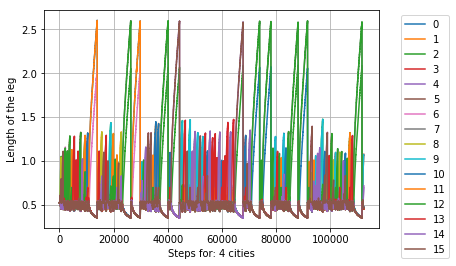

0 1.5129357320007475
2 1.5235089898018677
4 1.0166565529421236
1 1.523258799859248
3 0.7009567032703731


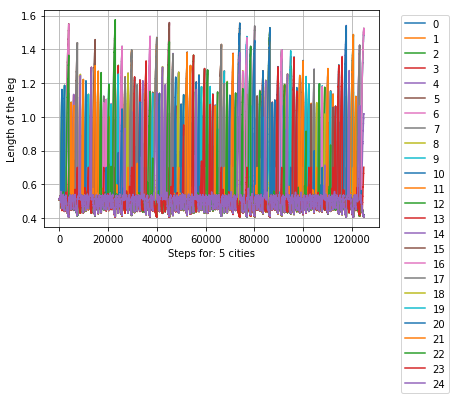

1 0.7002746520451858
4 1.3729188490307649
3 0.8775281295071096
2 1.3689676408332072
5 0.8684191151408525
0 1.369128917308331


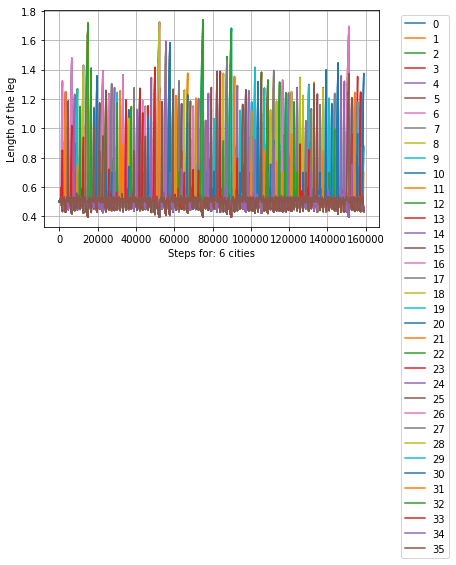

6 1.7493226499782044
3 0.7009170372311648
5 1.7463318648838253
1 1.7476144733345989
4 1.2939786807106253
2 1.744882115997313
0 1.3062019107250797


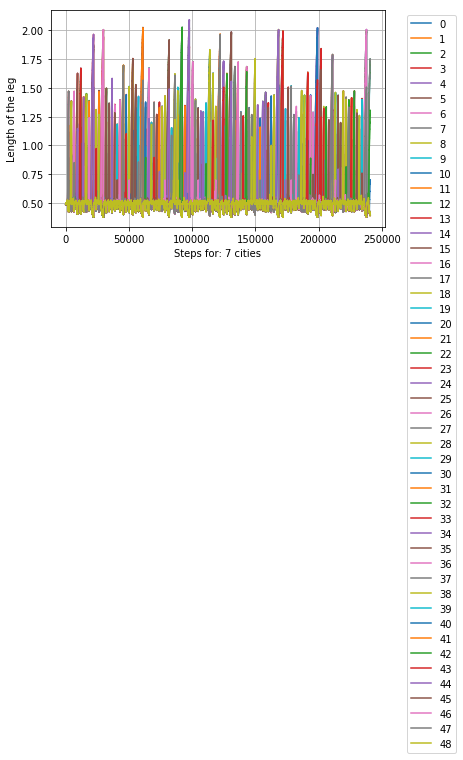

3 0.7005511801723966
6 1.2888065578401315
5 0.8143191789948573
2 1.291052354690883
0 0.8478106370934573
7 1.2876109942615657
1 0.853754349210723
4 1.287662242423059


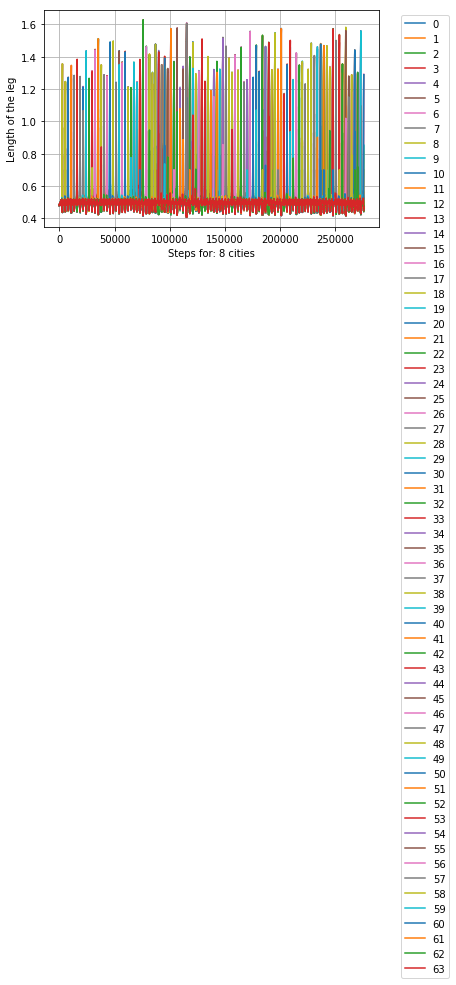

In [33]:
for idx, legdata in enumerate(list_legs):
    for i, leg in enumerate(legdata):
        if leg[-1] >= decided-0.01:
            print(i%(num_of_cities[idx]), leg[-1])
        x_values = np.arange(0, len(leg), 1)
        plt.plot(x_values, leg, "-", label = i)
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Length of the leg')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

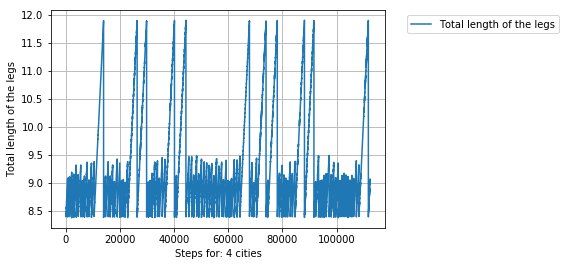

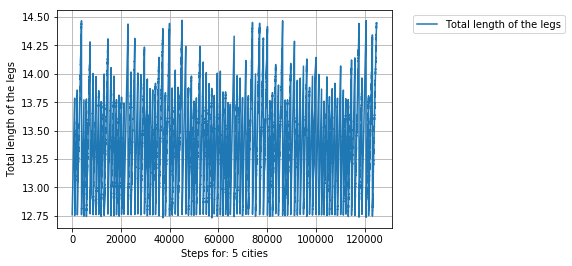

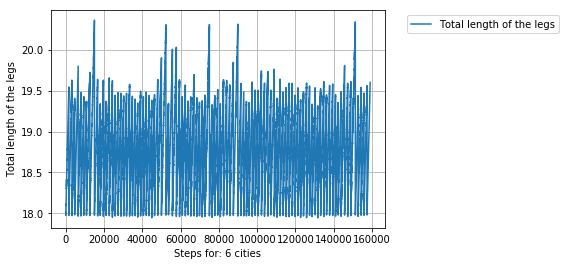

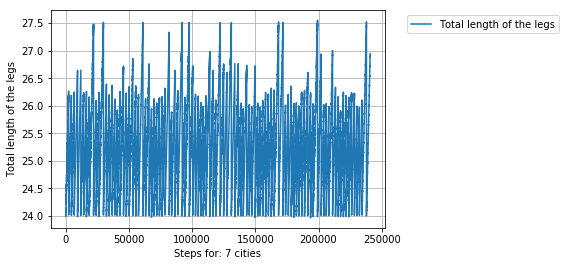

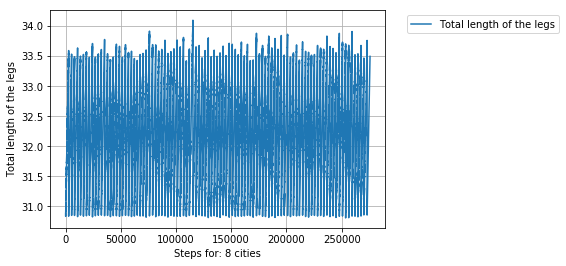

In [34]:
# statistics for  total length of legs
for idx, legdata in enumerate(list_legs):
    total_length_of_legs = np.zeros(len(legdata[0]))
    for i, leg in enumerate(legdata):
        total_length_of_legs += np.array(leg)
    x_values = np.arange(0, len(legdata[0]), 1)
    plt.plot(x_values, total_length_of_legs, "-", label = "Total length of the legs")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Total length of the legs')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

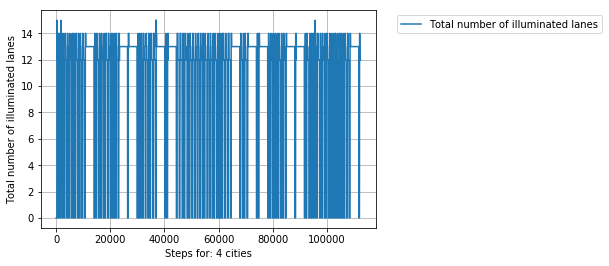

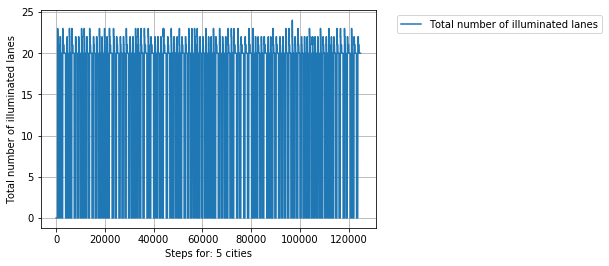

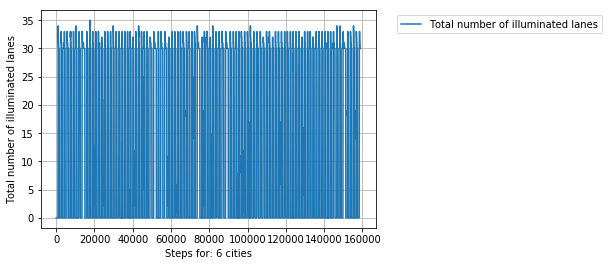

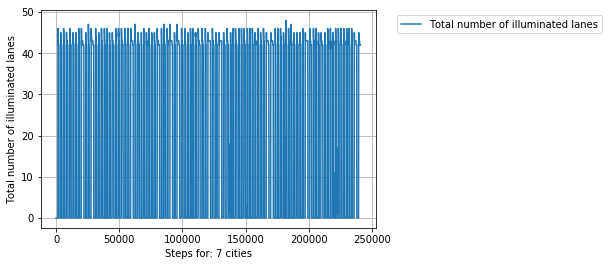

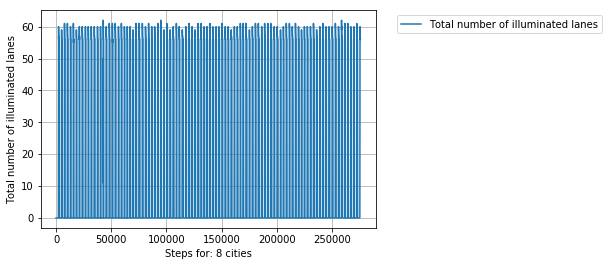

In [35]:
# statistics for  the total number of illu. lanes
for idx, illudata in enumerate(list_illu_lanes):
    x_values = np.arange(0, len(illudata), 1)
    plt.plot(x_values, illudata, "-", label = "Total number of illuminated lanes")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('Total number of illuminated lanes')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

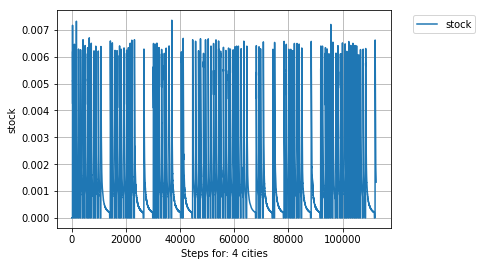

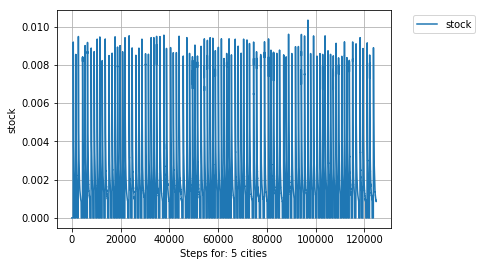

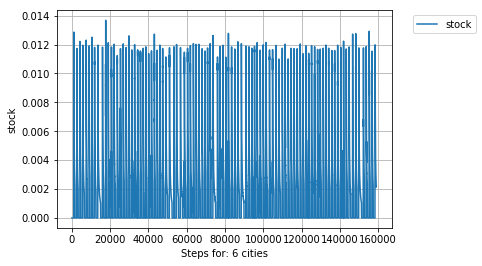

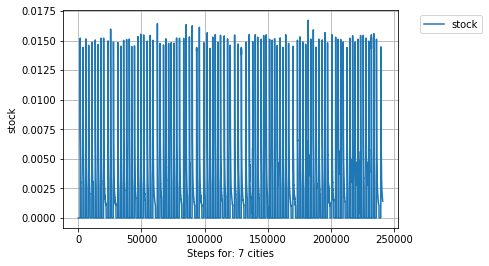

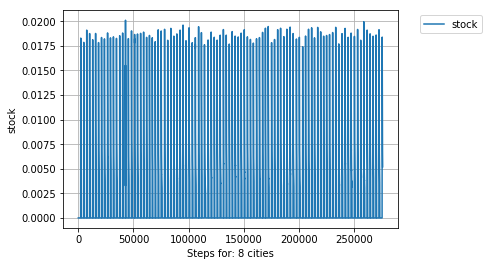

In [36]:
# statistics for  stock
for idx, stkdata in enumerate(list_stock):
    x_values = np.arange(0, len(stkdata), 1)
    plt.plot(x_values, stkdata, "-", label = "stock")
    plt.grid()                     # グリッドを表示
    plt.xlabel('Steps for: ' + str(num_of_cities[idx]) + " cities") # X軸のラベル
    plt.ylabel('stock')       # Y軸のラベル
    plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
    plt.show()

list_totalTfi: [0.3699570220654433, 1.1646832680693477, 3.0453445349712274, 7.798598754755544, 15.411100350361375]
list_time: [0.00014079100219532847, 9.023002348840237e-05, 0.00041260701254941523, 0.0022019300085958093, 0.019339555001351982]


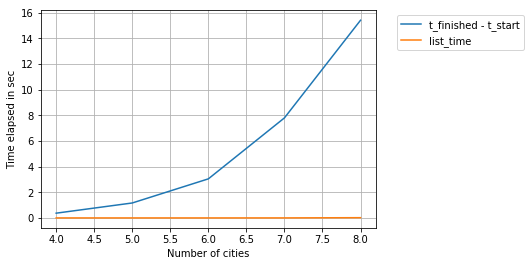

In [37]:
# statistics for time elapsed for TSP vs brute force
print("list_totalTfi:", list_totalTfi)
print("list_time:", list_time)

plt.plot(num_of_cities, list_totalTfi, "-", label = "t_finished - t_start")
plt.plot(num_of_cities, list_time, "-", label = "list_time")
plt.grid()                     # グリッドを表示
plt.xlabel('Number of cities') # X軸のラベル
plt.ylabel('Time elapsed in sec')       # Y軸のラベル
plt.legend(loc='upper left', bbox_to_anchor=( 1.05, 1.0 ))  # 凡例を枠外に表示
plt.show()